### This notebook implements attempt of Interpretation KAN:
1. Squeezing input curve to 5 values.
2. KAN fitting on data of 4 component task with squeezed input data. Predicting 1 component=ion.
3. Using different seeds to investigate several fitted activation functions.
4. Disable low value connetions (set them as 0).
5. Post fitting model and analyzing results.

Attention: In this notebook version of pykan=0.2.7

---
Functions, that are used in this notebook, are written in modules:
* raw_data_processing.py
* tools.py

In [80]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy, copy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from kan import KAN

from tqdm import tqdm

from raw_data_processing import get_x, get_y, get_wavelength
from tools import JSON_Read, plotly_multi_scatter, KAN_es
SCRIPT_DIR = os.path.abspath('')


def get_sqz_input(x_axis, y_axis):
    ''' Evaluate squeezed data from curve.
    '''
    i_max = np.argmax(y_axis)
    I = y_axis[i_max]  # Max I
    c_I = x_axis[i_max]  # Coordinate of max I

    diff_I = np.absolute(y_axis-I/2)
    c_I2_left = x_axis[ np.argmin(diff_I[:i_max]) ]  # Left I/2 coordinate
    c_I2_right = x_axis[ np.argmin(diff_I[i_max:])+i_max]  # Right I/2 coordinate

    c_I2 = np.mean([c_I2_left, c_I2_right])  # Mean center coordinate on I/2 
    disp_I2 = np.abs(c_I2_right-c_I2_left)  # Width of curve on I/2 y-level

    integr_ratio = np.sum(y_axis[i_max+1:]) / np.sum(y_axis[:i_max])

    sqz_input = [I, c_I, c_I2, disp_I2, integr_ratio]
    
    
    return sqz_input

def get_all_sqz_input(matr_x, matr_y):
    matr_sqz_input = []
    for x_axis, y_axis in zip(matr_x, matr_y):
        matr_sqz_input.append(get_sqz_input(x_axis, y_axis))


    return np.array(matr_sqz_input)

def scatter_prediction_kan(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.forward(x).detach().numpy()
    y_true = y_true.detach().numpy()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=4, alpha = 0.8) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(float(mse), 3)} | RMSE={round(float(mse)**0.5, 3)} | R2={round(float(r2), 3)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()

    
    return mse, r2

d_config = JSON_Read("", "json_config.txt")
EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = ['Cr']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE']

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']
MAX_ITER = d_config['MAX_ITER']

x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
#y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)

x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()
x = get_all_sqz_input(x_matrix, y_matrix)

# Interpretability investigation

# $Cr$

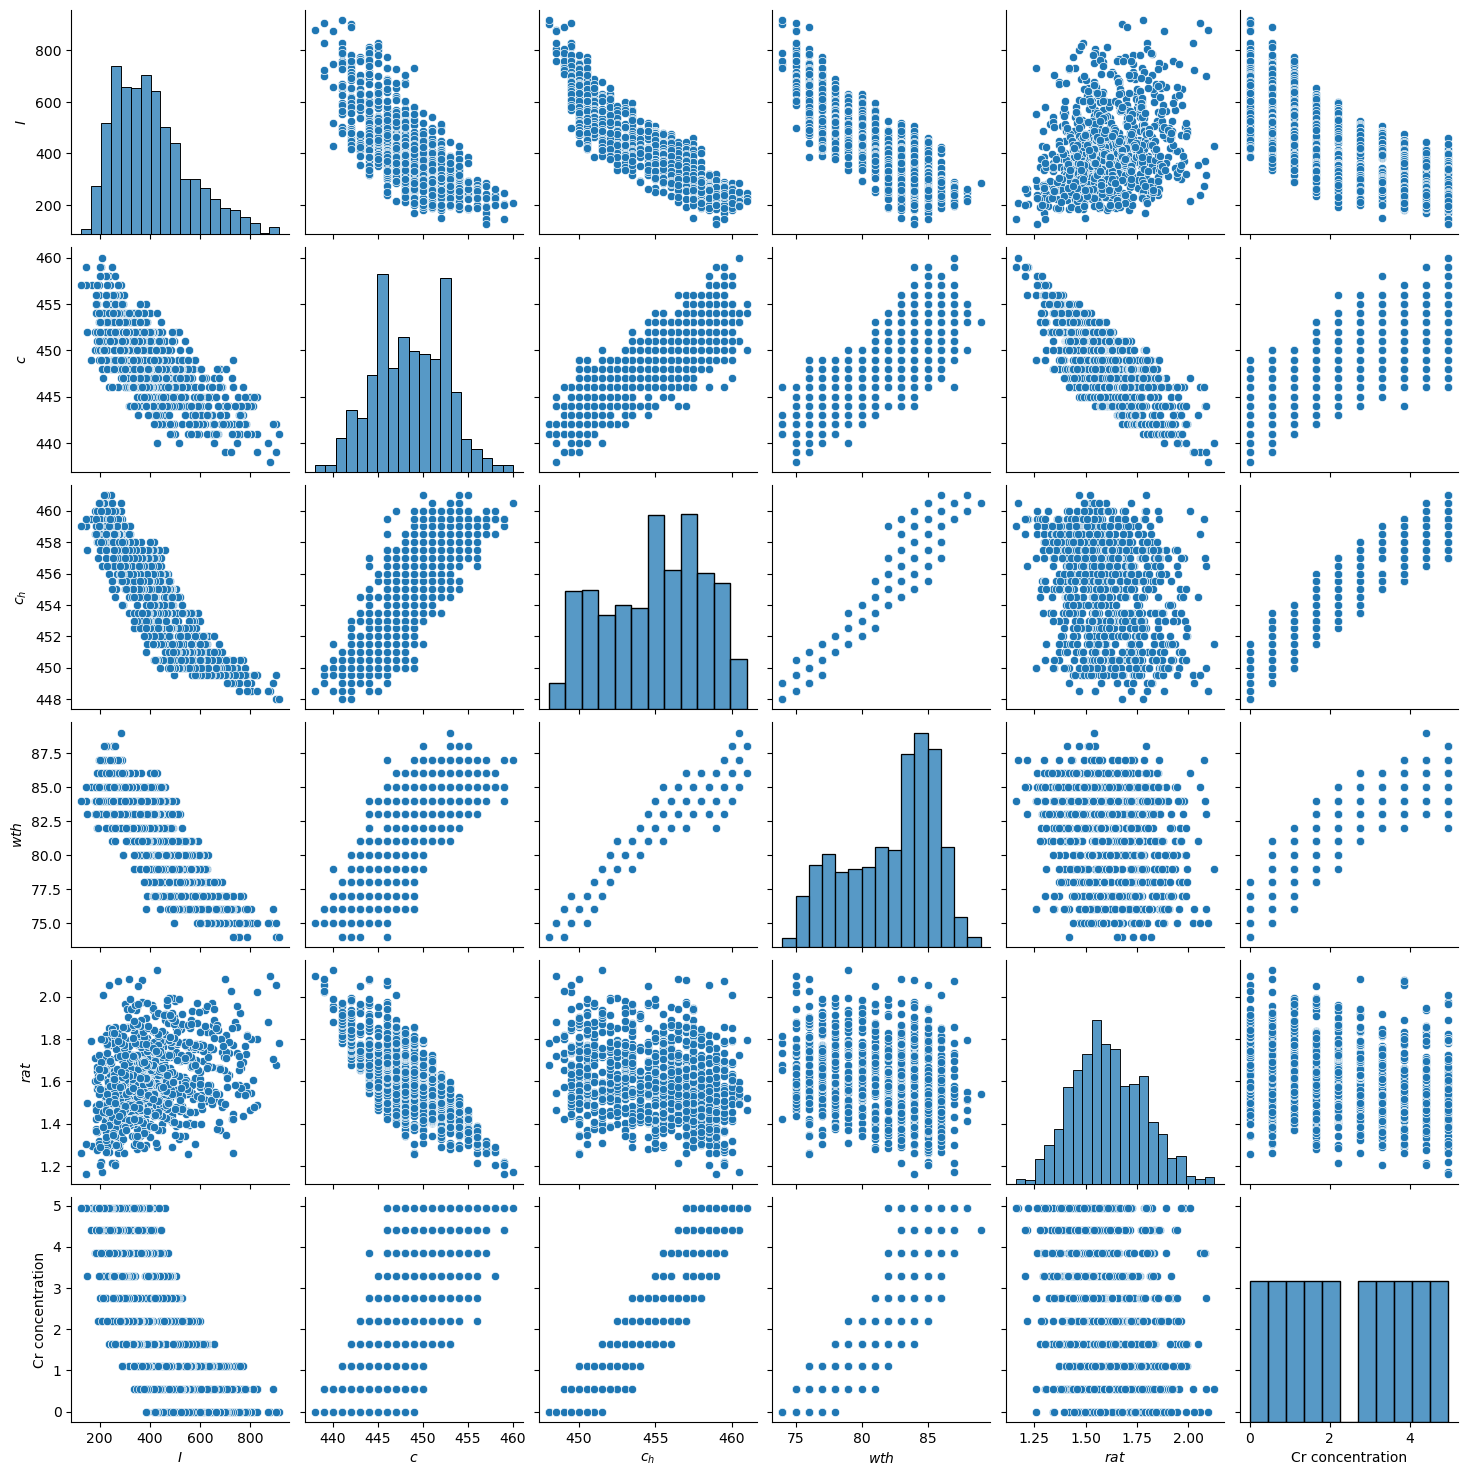

In [117]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Cr']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''

tc_x_train = torch.tensor(x_train, dtype=torch.float)
tc_y_train = torch.tensor(y_train.reshape([-1,1]), dtype=torch.float)
tc_x_test = torch.tensor(x_test, dtype=torch.float)
tc_y_test = torch.tensor(y_test.reshape([-1,1]), dtype=torch.float)

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

INPUT_SHAPE = tc_x_train.shape[1]

In [57]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(squeezed_df.loc[:,['$I$', '$c$', '$rat$', PREDICT_IONS[0] + ' concentration']], 
                    x='$I$', y='$rat$', z='$c$',
                    color= PREDICT_IONS[0] + ' concentration',
                    opacity=1)

fig.update_traces(marker_size = 4)
fig.show()

In [62]:
squeezed_df1 = squeezed_df.loc[:,['$I$', '$c$', '$rat$', PREDICT_IONS[0] + ' concentration']]
squeezed_df1.columns = ['I', 'c', 'rat', PREDICT_IONS[0] + ' concentration']


fig = px.scatter_matrix(
    squeezed_df1,
    dimensions=['I', 'c', 'rat'],
    color=PREDICT_IONS[0] + ' concentration'
)
#fig.update_traces(diagonal_visible=False)

fig.update_layout(
    #title=dict(text='Iris Data set'),
    width=1000,
    height=800,
)

fig.show()

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.29e-01 | test_loss: 3.90e-01 | reg: 9.31e+00 | : 100%|█| 20/20 [00:11<00:00,  1.80it


saving model version 0.1


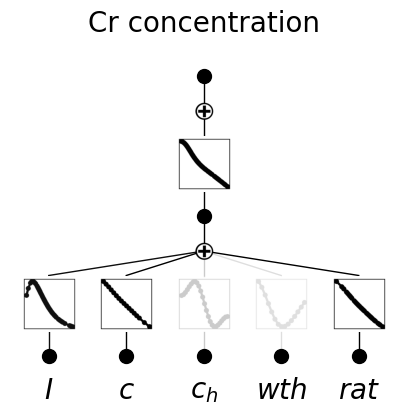

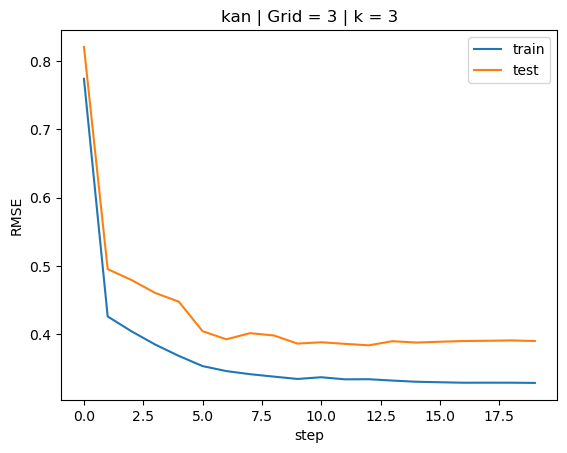

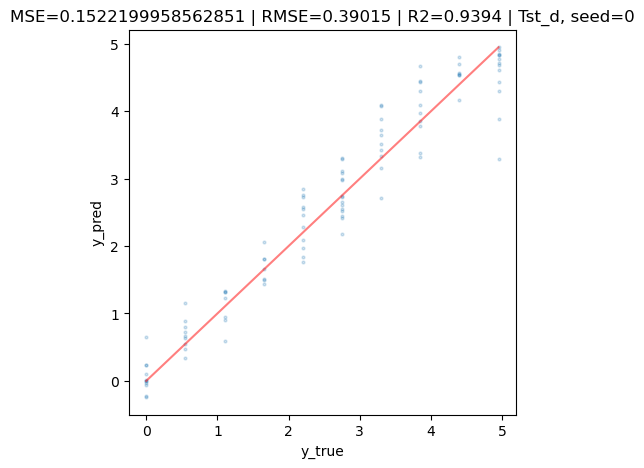

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.42e-01 | test_loss: 3.99e-01 | reg: 9.27e+00 | : 100%|█| 20/20 [00:08<00:00,  2.30it


saving model version 0.1


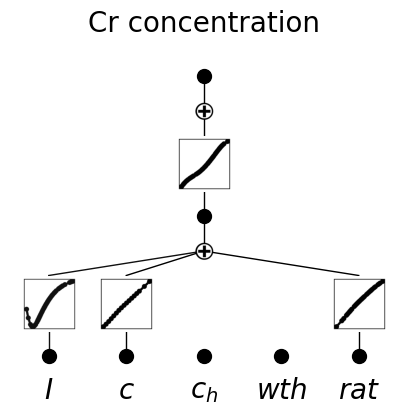

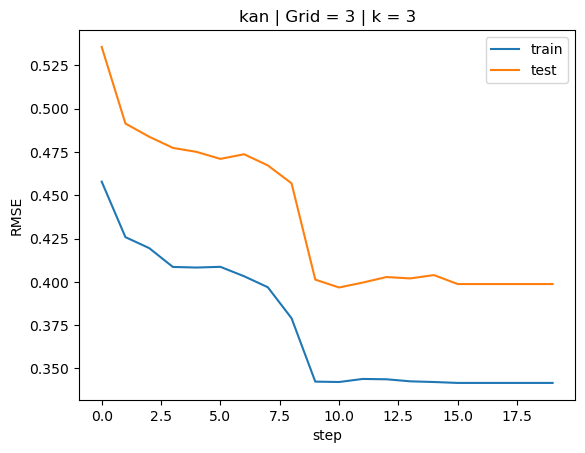

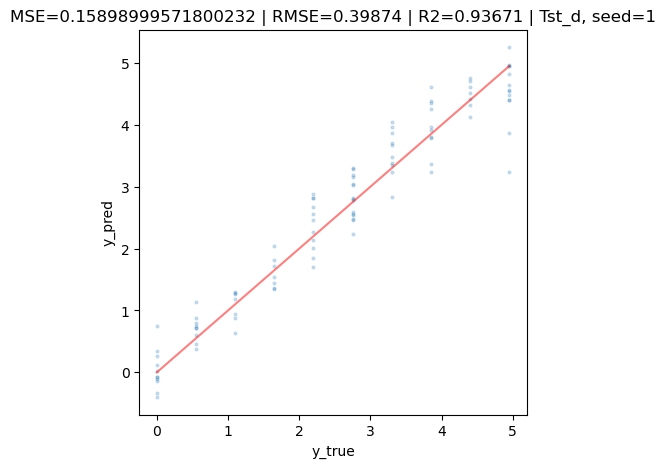

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.96e-01 | test_loss: 4.65e-01 | reg: 7.58e+00 | : 100%|█| 20/20 [00:26<00:00,  1.32s/


saving model version 0.1


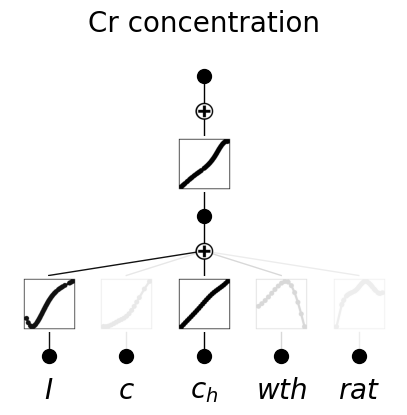

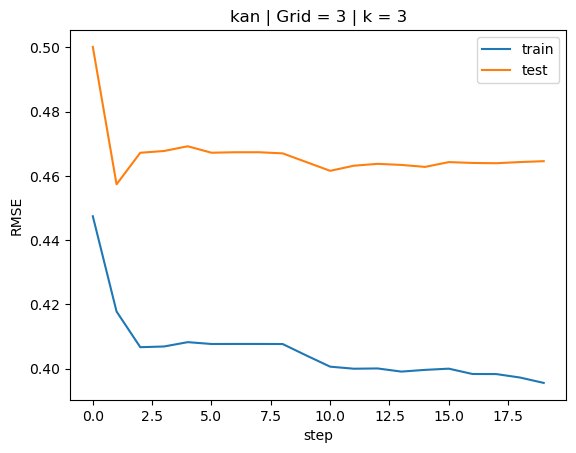

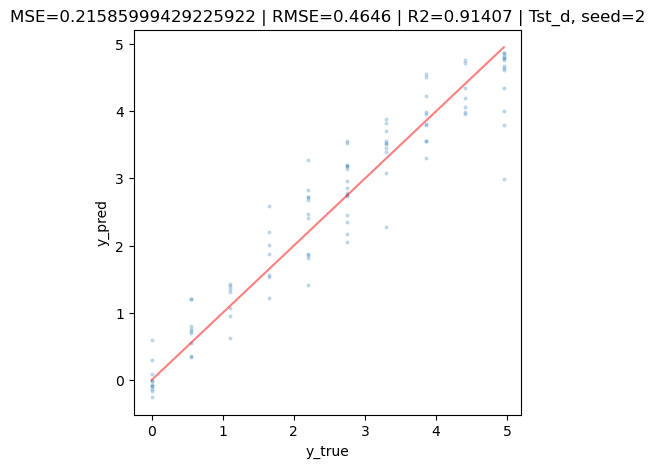

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e-01 | test_loss: 3.92e-01 | reg: 9.14e+00 | : 100%|█| 20/20 [00:11<00:00,  1.76it


saving model version 0.1


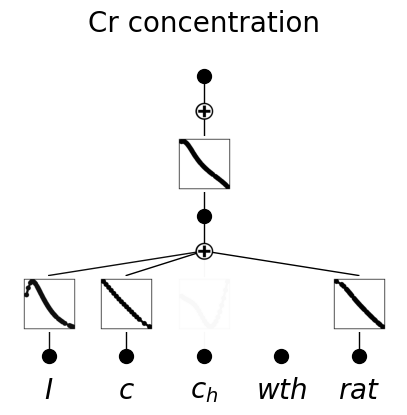

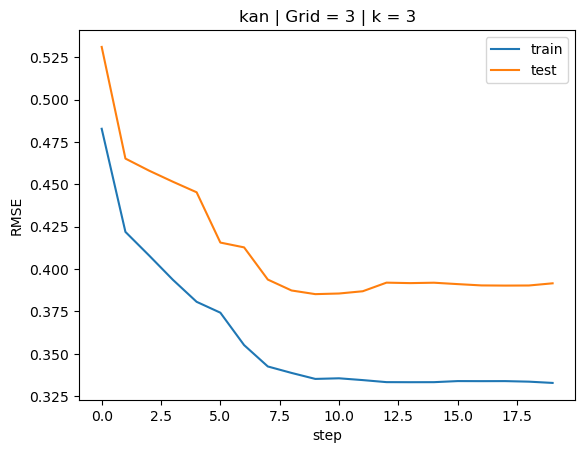

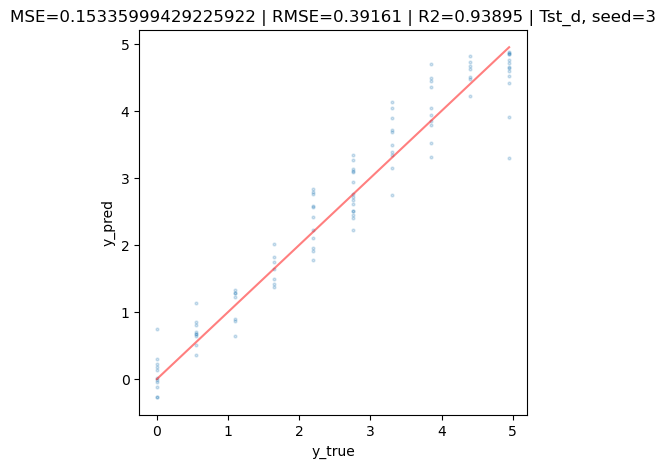

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.36e-01 | test_loss: 3.97e-01 | reg: 9.50e+00 | : 100%|█| 20/20 [00:06<00:00,  2.94it


saving model version 0.1


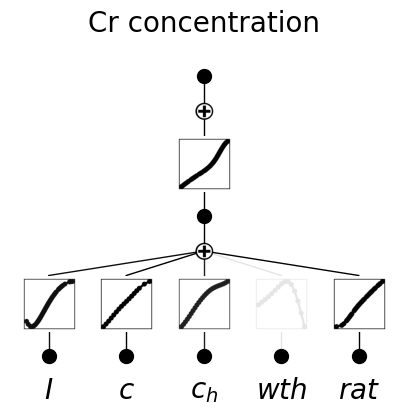

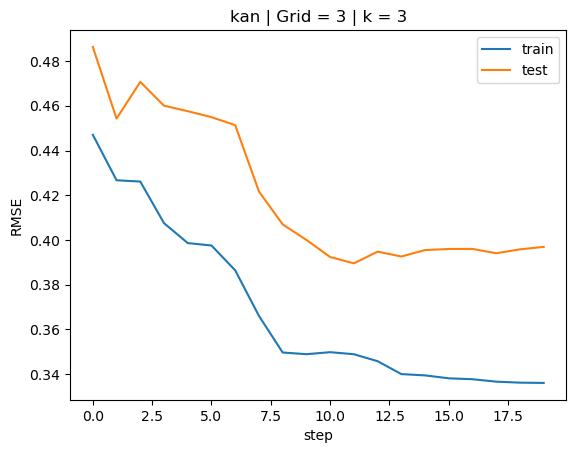

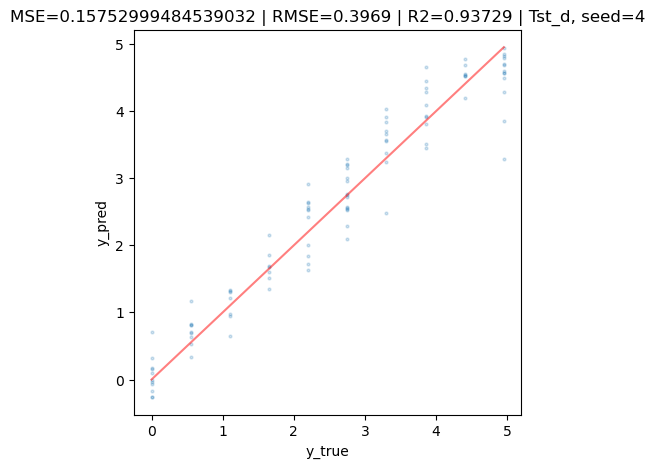

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.91e-01 | test_loss: 4.62e-01 | reg: 7.98e+00 | : 100%|█| 20/20 [00:07<00:00,  2.69it


saving model version 0.1


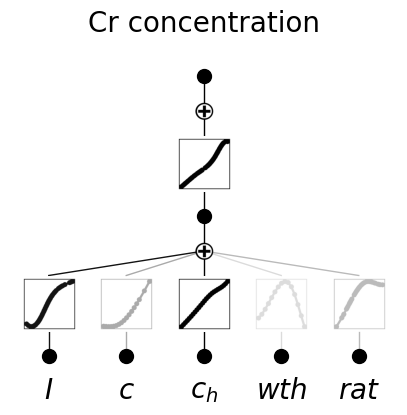

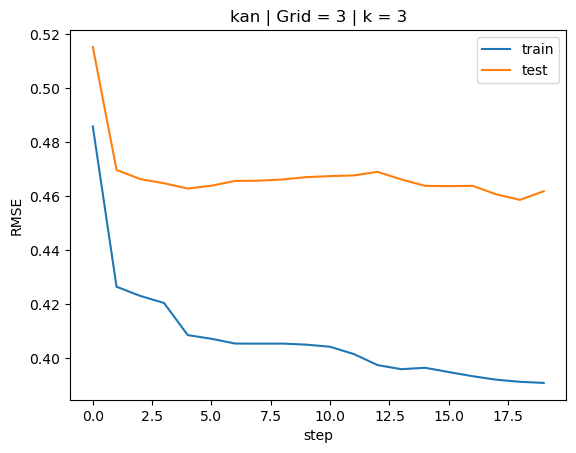

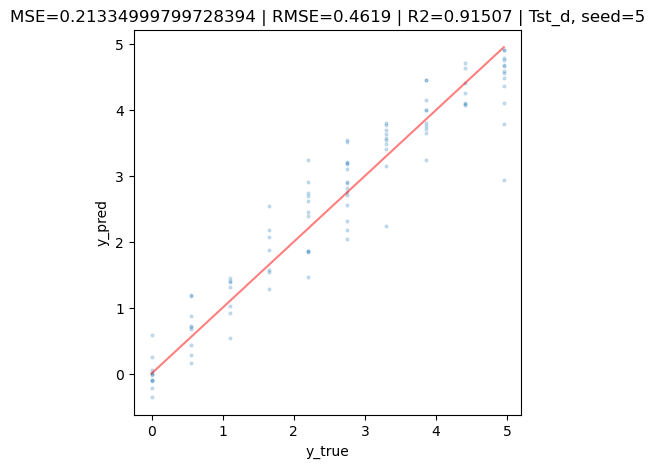

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.27e-01 | test_loss: 3.82e-01 | reg: 9.44e+00 | : 100%|█| 20/20 [00:07<00:00,  2.82it


saving model version 0.1


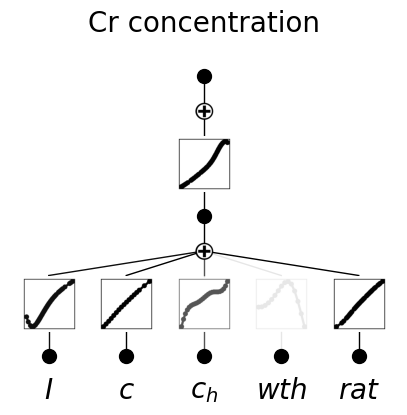

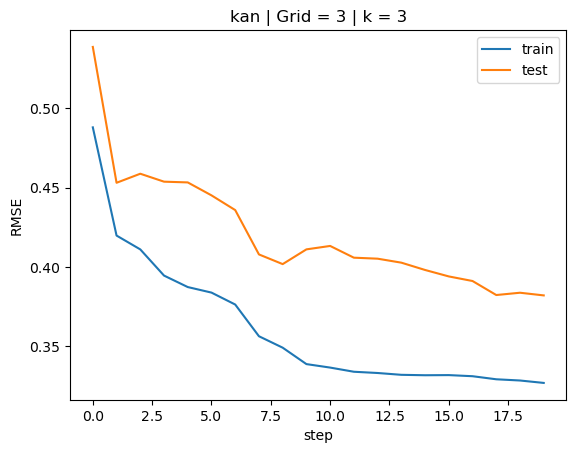

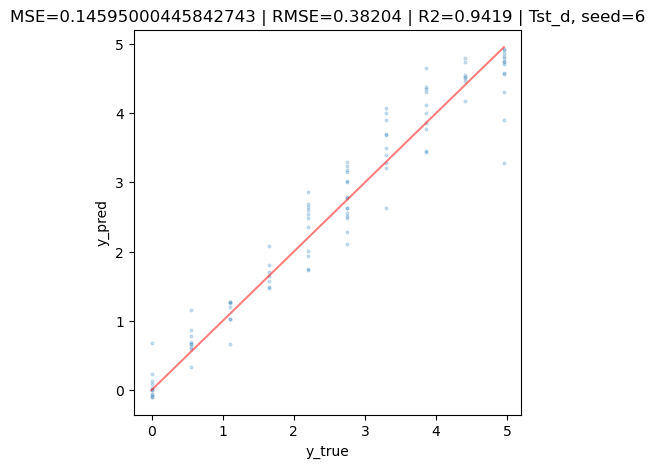

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.29e-01 | test_loss: 3.90e-01 | reg: 9.50e+00 | : 100%|█| 20/20 [00:07<00:00,  2.52it


saving model version 0.1


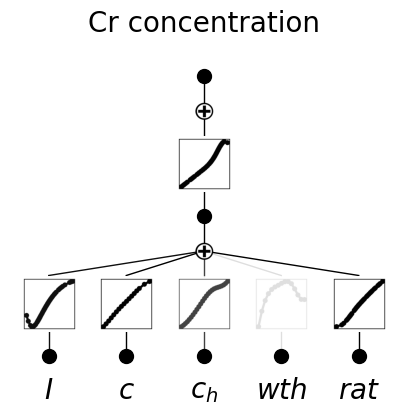

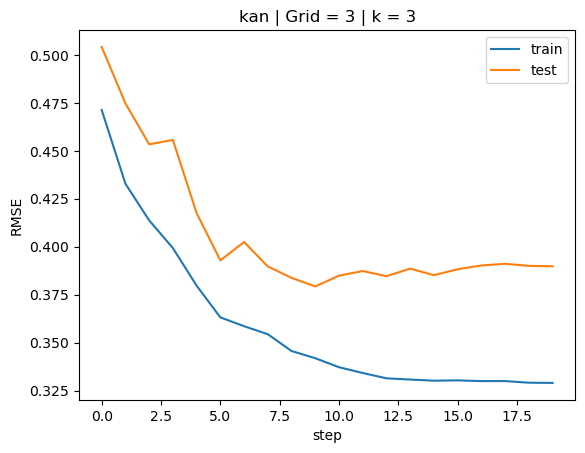

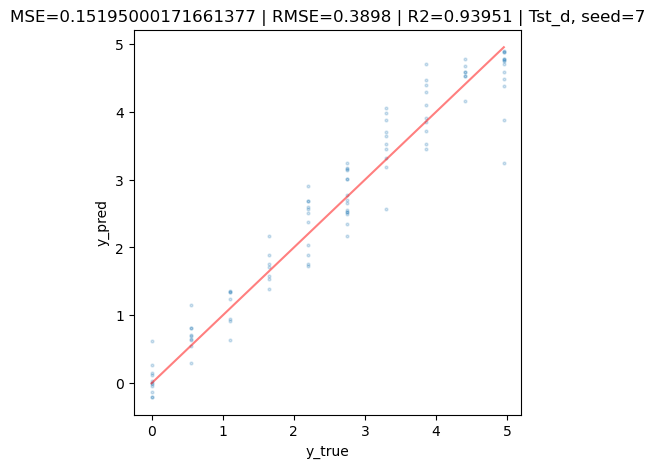

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.25e-01 | test_loss: 3.86e-01 | reg: 9.46e+00 | : 100%|█| 20/20 [00:07<00:00,  2.55it


saving model version 0.1


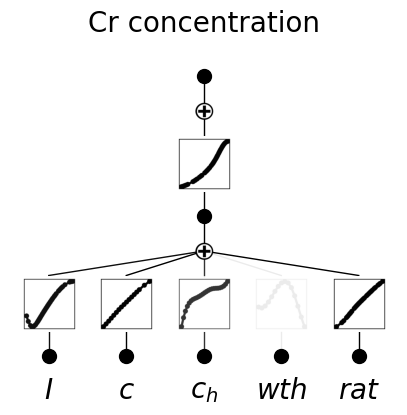

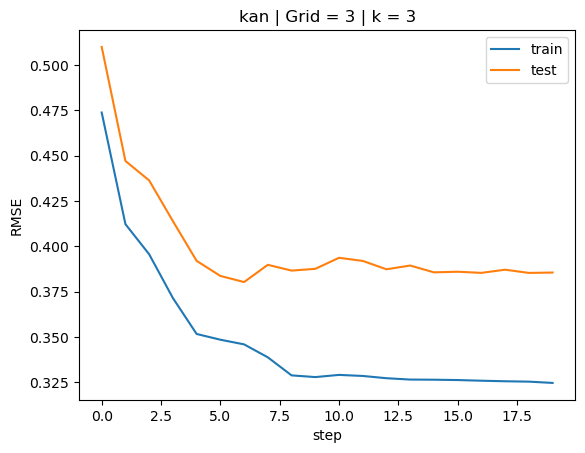

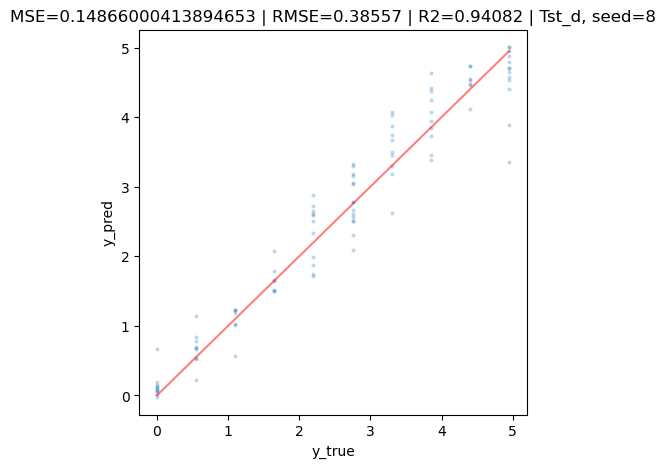

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.30e-01 | test_loss: 3.88e-01 | reg: 9.05e+00 | : 100%|█| 20/20 [00:08<00:00,  2.45it


saving model version 0.1


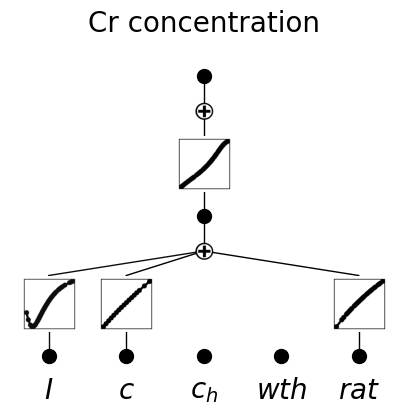

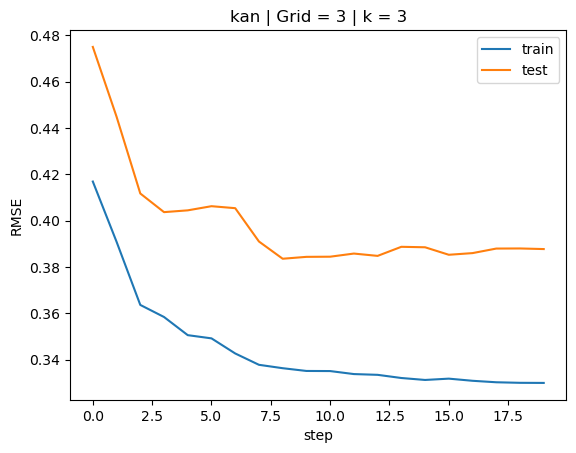

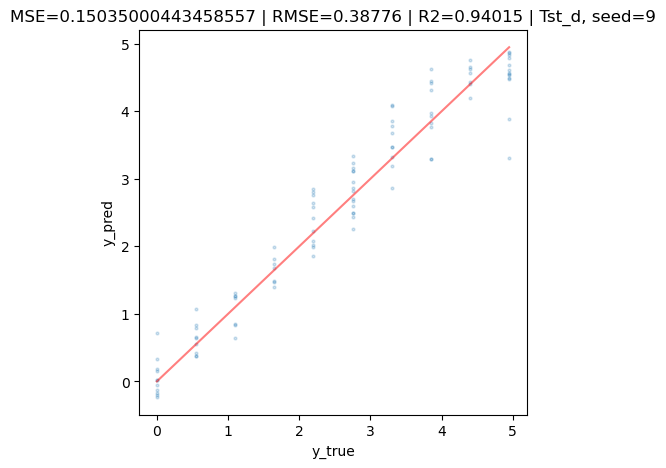

In [ ]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)
    result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                           lamb=1e-2,
                           lamb_l1=1,
                           lamb_entropy=2
                           )

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    INPUT_SHAPE = tc_x_test.shape[1]
    prnt_kwrgs = {'in_vars': VAR, 
                    'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                    'title': None,
                    'sample': True,
                    'scale': 0.5}
    
    model2.plot(**prnt_kwrgs)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    #scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
    scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Tst_d, seed={seed}")

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 3.13e-01 | test_loss: 3.80e-01 | reg: 9.43e+00 | : 100%|█| 20/20 [00:06<00:00,  3.06it


saving model version 0.1


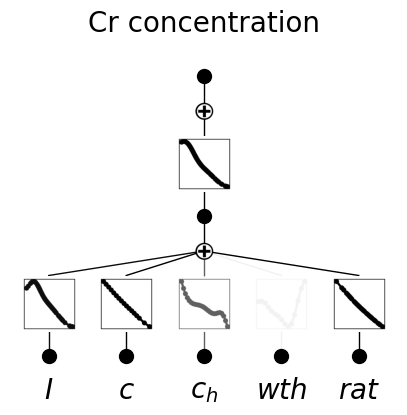

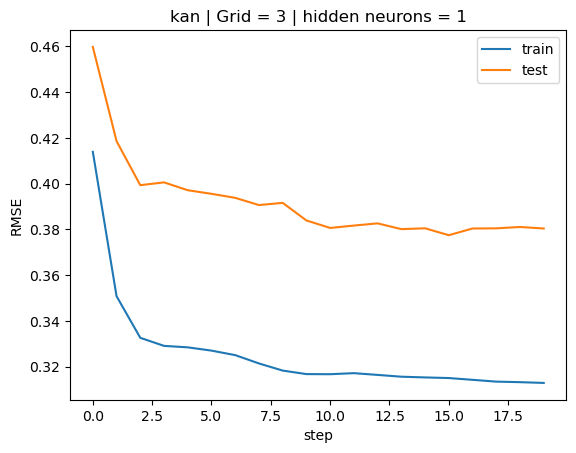

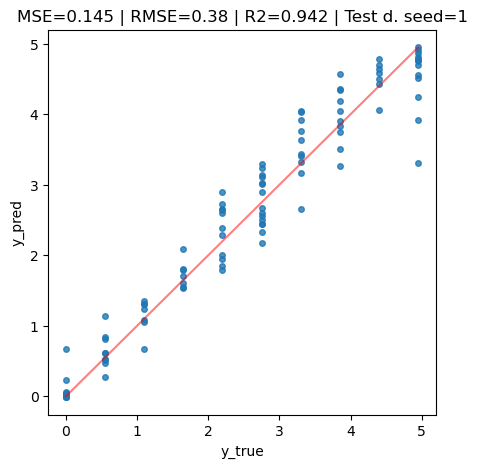

(0.14472727, 0.9423875212669373)

In [ ]:
# Choose seed and train again
seed = 1
print(f'==========\n- {seed=} -\n==========')

model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)

result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
INPUT_SHAPE = tc_x_test.shape[1]
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }
model2.plot(**prnt_kwrgs)
plt.show()

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

#scatter_prediction_kan(model2, tc_x_train, tc_y_train, f"Train d. seed={seed}")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Test d. seed={seed}")

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    0.995710  -7.861453           1                1   -0.772291
1      cos    0.999735 -11.830146           2                2   -0.766029
2      sin    0.999735 -11.829833           2                2   -0.765967
3      x^2    0.999407 -10.695824           2                2   -0.539165
4      exp    0.999315 -10.490377           2                2   -0.498075


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 0.995710015296936,
 1)

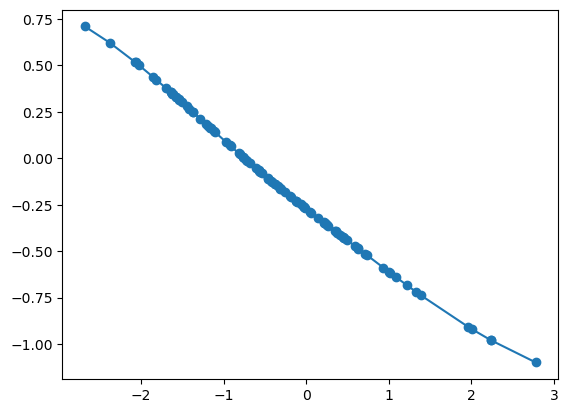

In [ ]:
# suggest activation function
l = 0#1
i = 4#0
j = 0#0

inputs = model2.spline_preacts[l][:,j,i]
outputs = model2.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

model2.suggest_symbolic(l,i,j)

In [120]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 3#0
j = 0#0

model2.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2(dataset['train_input'])

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3


| train_loss: 3.18e-01 | test_loss: 3.94e-01 | reg: 9.87e+00 | : 100%|█| 20/20 [00:08<00:00,  2.38it

saving model version 0.4


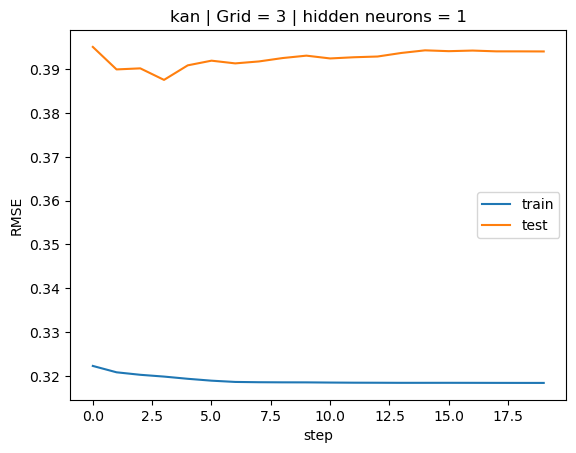

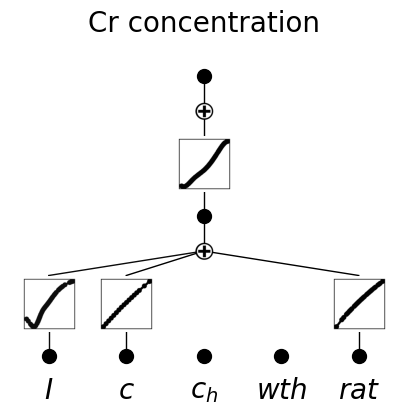

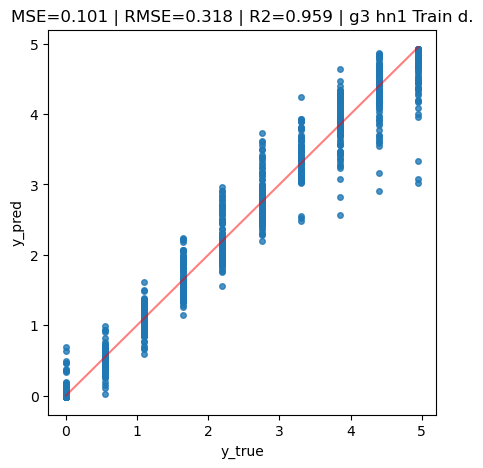

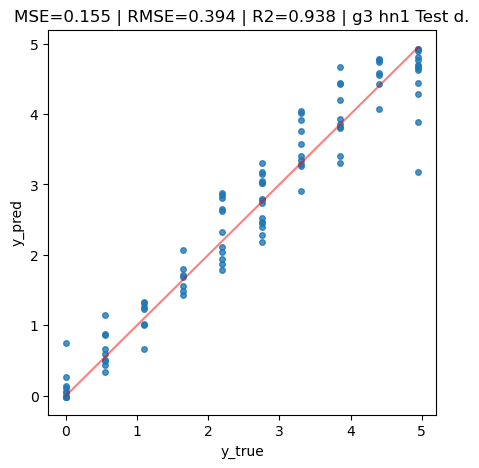

(0.15528347, 0.9381853342056274)

In [121]:
# POSTFITTING reduced KAN
result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-3,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

model2.plot(**prnt_kwrgs)

scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")

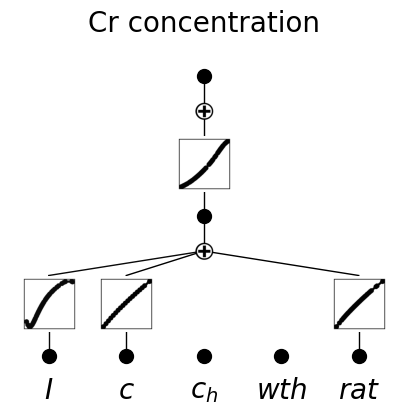

In [76]:
model2.plot(**prnt_kwrgs)

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.96e-01 | test_loss: 4.65e-01 | reg: 7.58e+00 | : 100%|█| 20/20 [00:07<00:00,  2.82it


saving model version 0.1


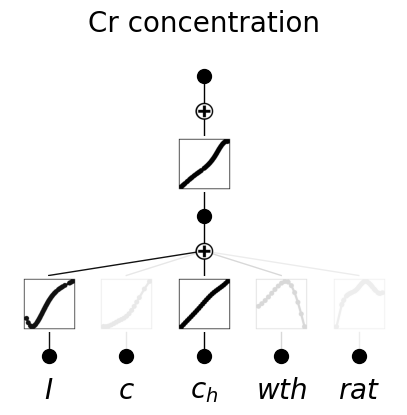

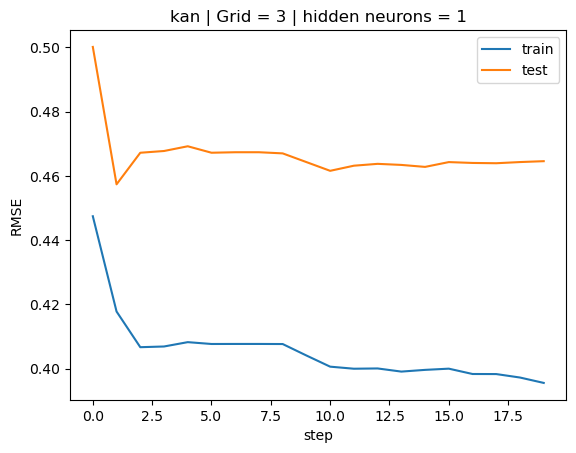

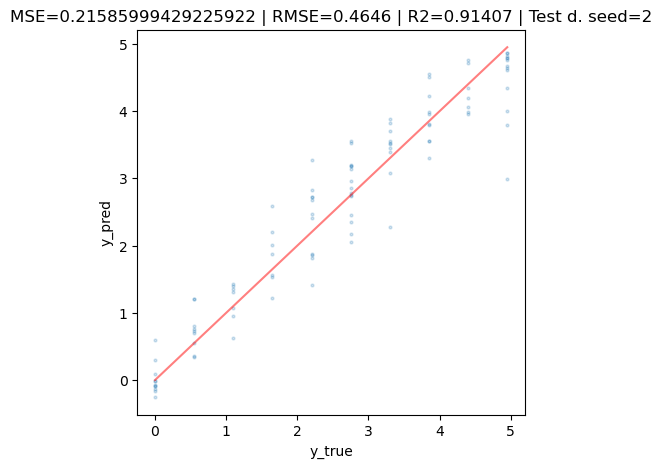

(0.2158558, 0.9140729308128357)

In [28]:
# Choose seed and train again
seed = 2
print(f'==========\n- {seed=} -\n==========')

model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)

result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
INPUT_SHAPE = tc_x_test.shape[1]
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }
model2.plot(**prnt_kwrgs)
plt.show()

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

#scatter_prediction_kan(model2, tc_x_train, tc_y_train, f"Train d. seed={seed}")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Test d. seed={seed}")

In [31]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 4#0
j = 0#0

model2.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2(dataset['train_input'])

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.4


| train_loss: 4.02e-01 | test_loss: 4.67e-01 | reg: 7.62e+00 | : 100%|█| 20/20 [00:08<00:00,  2.43it


saving model version 0.5


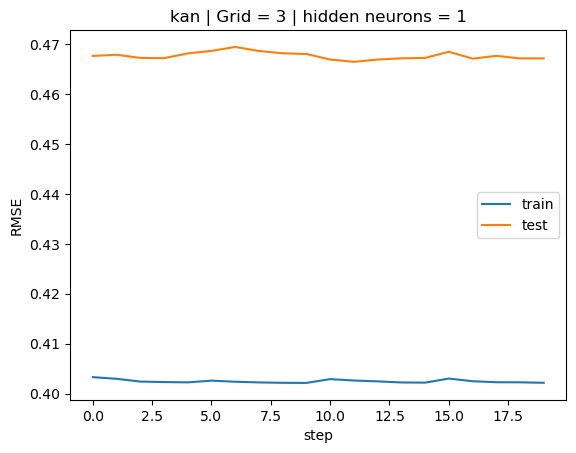

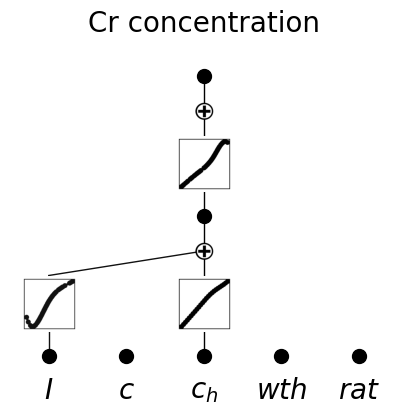

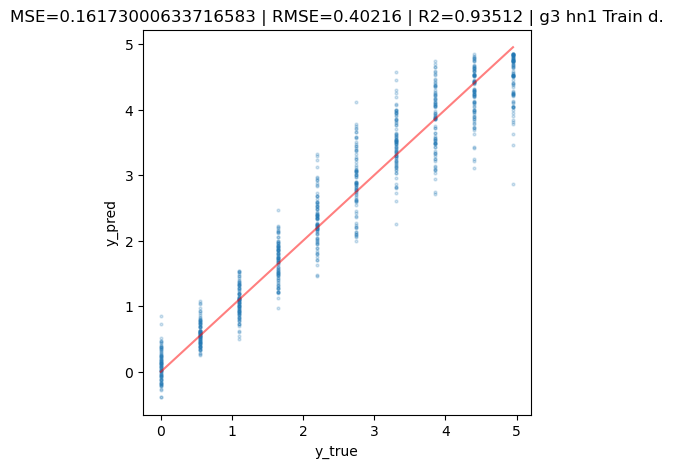

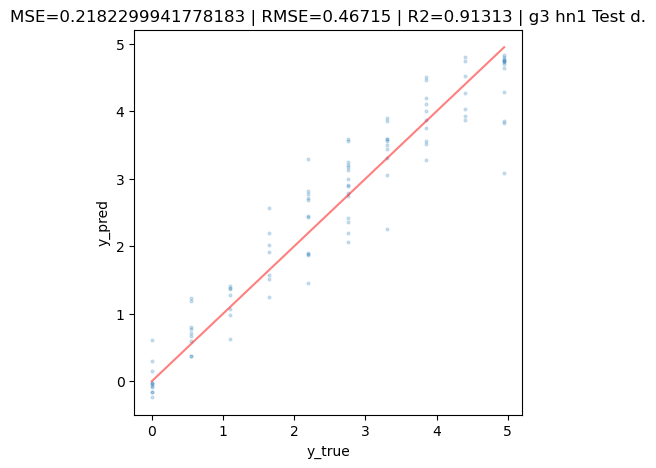

(0.21823248, 0.9131268262863159)

In [32]:
# POSTFITTING reduced KAN
result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-3,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

model2.plot(**prnt_kwrgs)

scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")

# $Cu$

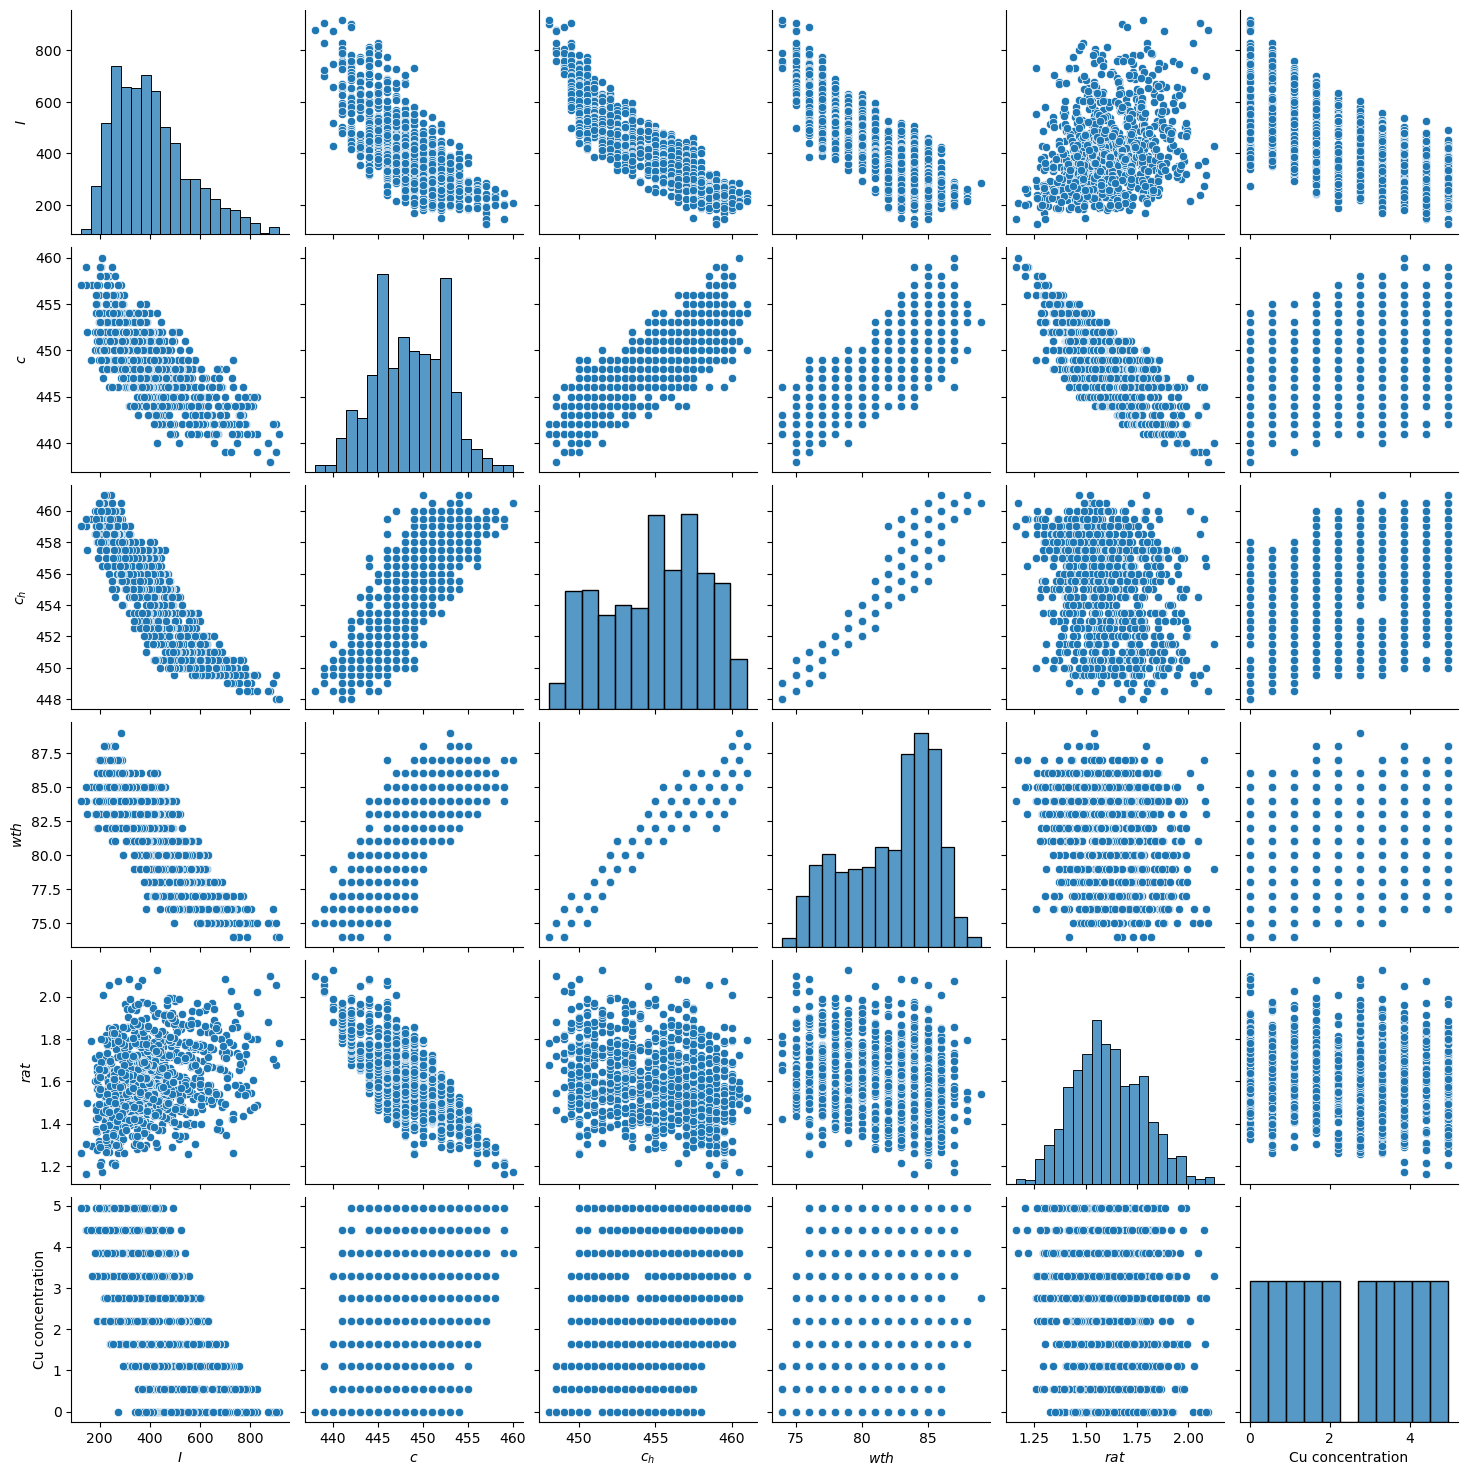

In [123]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Cu']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''

tc_x_train = torch.tensor(x_train, dtype=torch.float)
tc_y_train = torch.tensor(y_train.reshape([-1,1]), dtype=torch.float)
tc_x_test = torch.tensor(x_test, dtype=torch.float)
tc_y_test = torch.tensor(y_test.reshape([-1,1]), dtype=torch.float)

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

INPUT_SHAPE = tc_x_train.shape[1]

In [125]:
squeezed_df1 = squeezed_df.loc[:,['$I$', '$c_h$', '$wth$', PREDICT_IONS[0] + ' concentration']]
squeezed_df1.columns = ['I', 'c_h', 'wth', PREDICT_IONS[0] + ' concentration']


fig = px.scatter_matrix(
    squeezed_df1,
    dimensions=['I', 'c_h', 'wth'],
    color=PREDICT_IONS[0] + ' concentration'
)
#fig.update_traces(diagonal_visible=False)

fig.update_layout(
    #title=dict(text='Iris Data set'),
    width=1000,
    height=800,
)

fig.show()

In [ ]:
squeezed_df1 = squeezed_df.loc[:,['$I$', '$c$', '$rat$', PREDICT_IONS[0] + ' concentration']]
squeezed_df1.columns = ['I', 'c', 'rat', PREDICT_IONS[0] + ' concentration']


fig = px.scatter_matrix(
    squeezed_df1,
    dimensions=['I', 'c', 'rat'],
    color=PREDICT_IONS[0] + ' concentration'
)
#fig.update_traces(diagonal_visible=False)

fig.update_layout(
    #title=dict(text='Iris Data set'),
    width=1000,
    height=800,
)

fig.show()

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.25e-01 | test_loss: 7.37e-01 | reg: 8.57e+00 | : 100%|█| 20/20 [00:06<00:00,  2.92it


saving model version 0.1


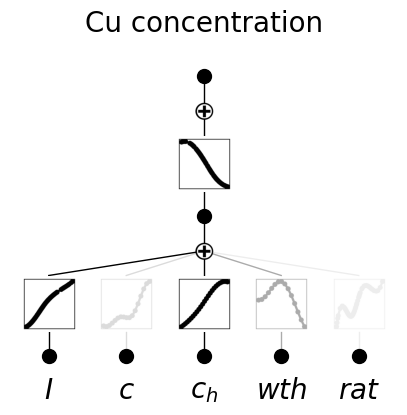

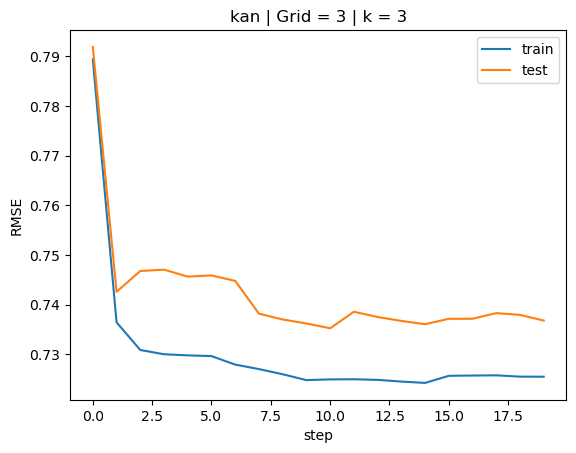

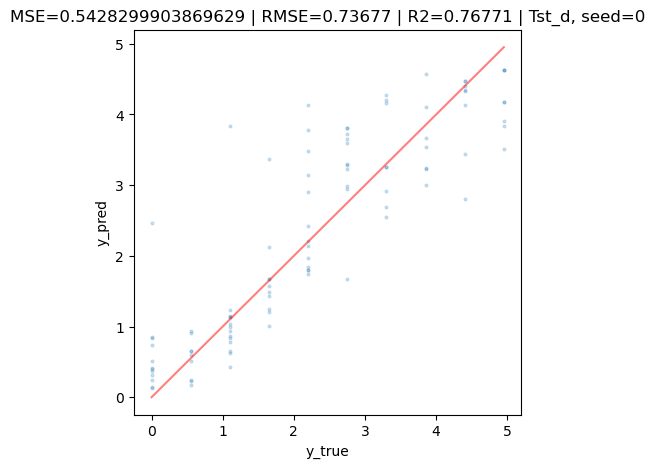

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.27e-01 | test_loss: 7.39e-01 | reg: 8.38e+00 | : 100%|█| 20/20 [00:07<00:00,  2.61it


saving model version 0.1


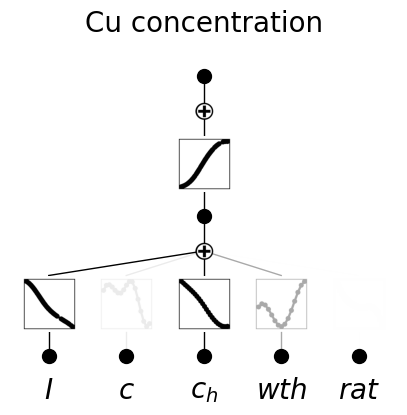

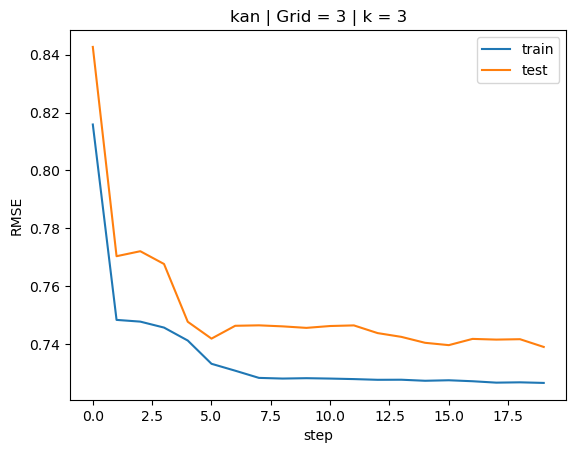

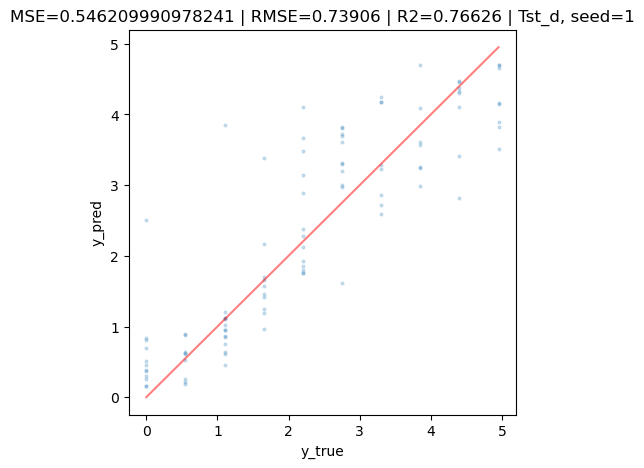

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.27e-01 | test_loss: 7.38e-01 | reg: 8.39e+00 | : 100%|█| 20/20 [00:07<00:00,  2.58it


saving model version 0.1


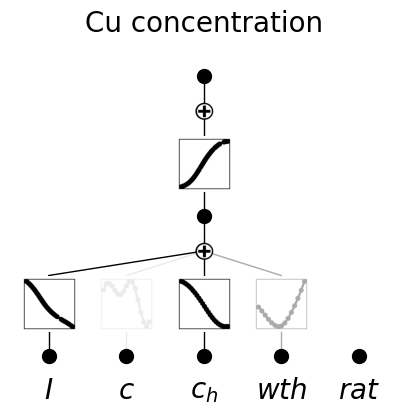

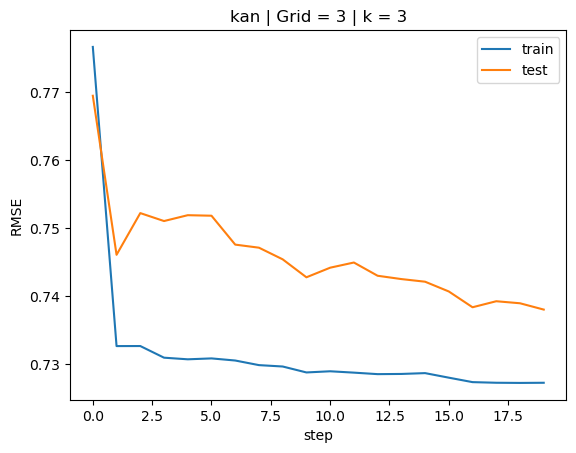

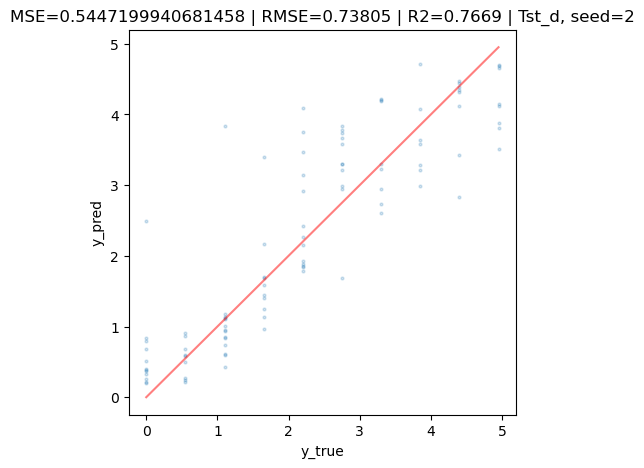

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.29e-01 | test_loss: 7.38e-01 | reg: 8.34e+00 | : 100%|█| 20/20 [00:09<00:00,  2.11it


saving model version 0.1


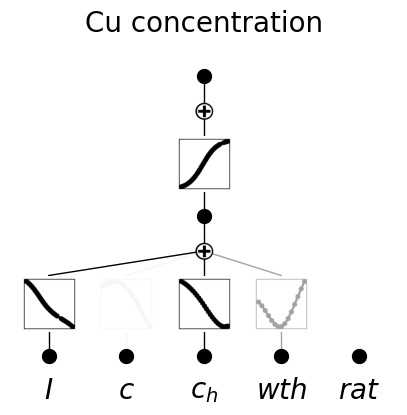

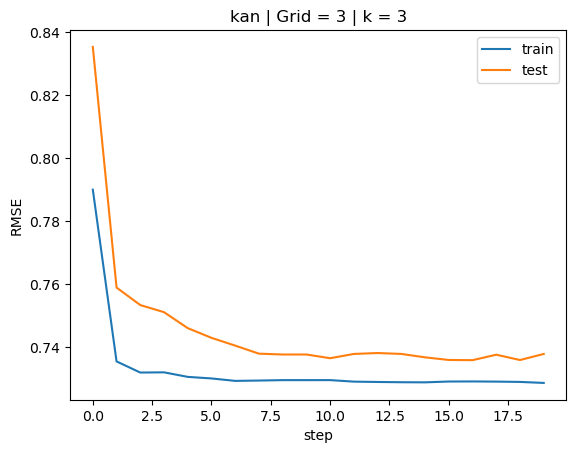

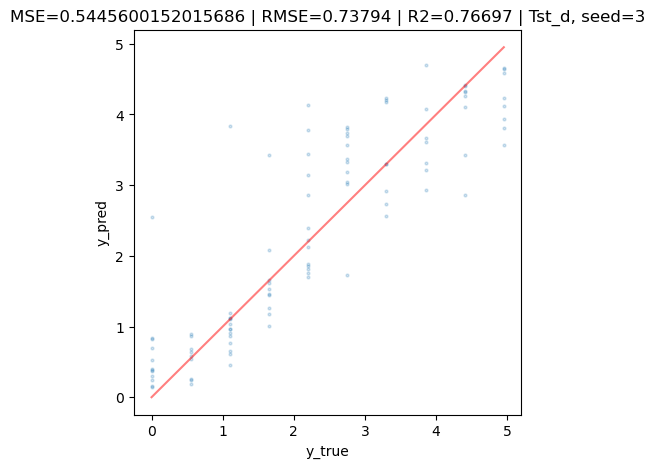

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.13e-01 | test_loss: 7.19e-01 | reg: 1.01e+01 | : 100%|█| 20/20 [00:07<00:00,  2.61it


saving model version 0.1


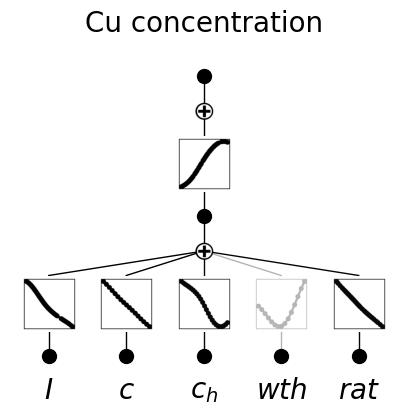

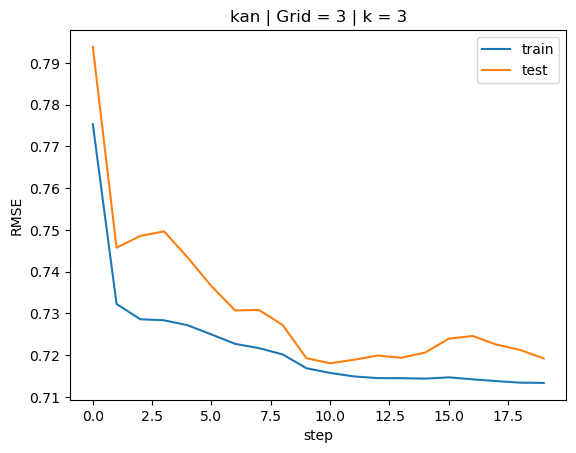

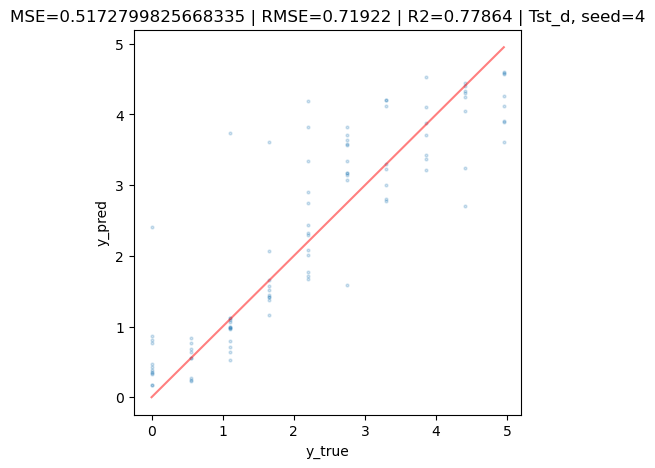

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.28e-01 | test_loss: 7.39e-01 | reg: 8.38e+00 | : 100%|█| 20/20 [00:08<00:00,  2.43it


saving model version 0.1


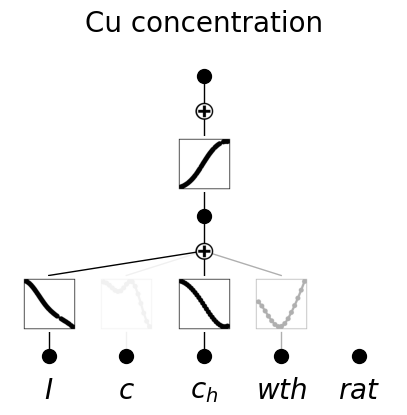

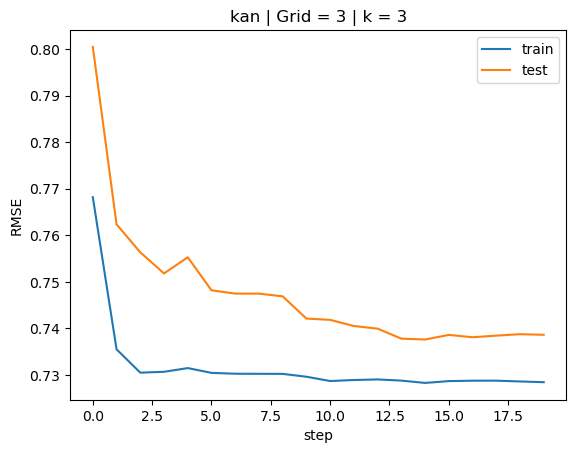

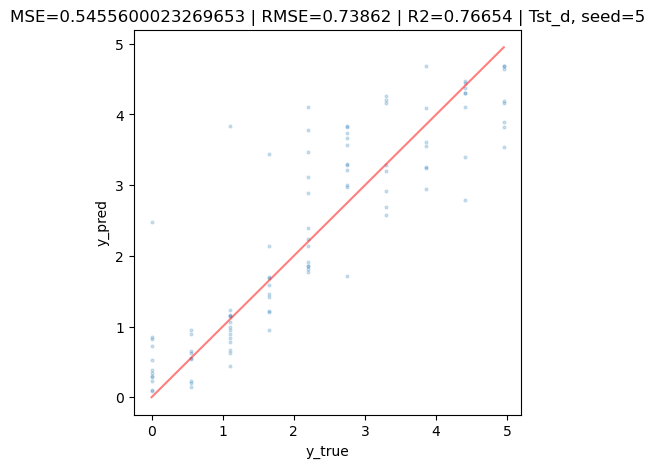

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.15e-01 | test_loss: 7.18e-01 | reg: 9.96e+00 | : 100%|█| 20/20 [00:08<00:00,  2.38it


saving model version 0.1


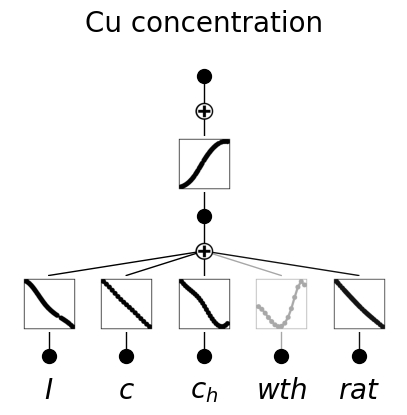

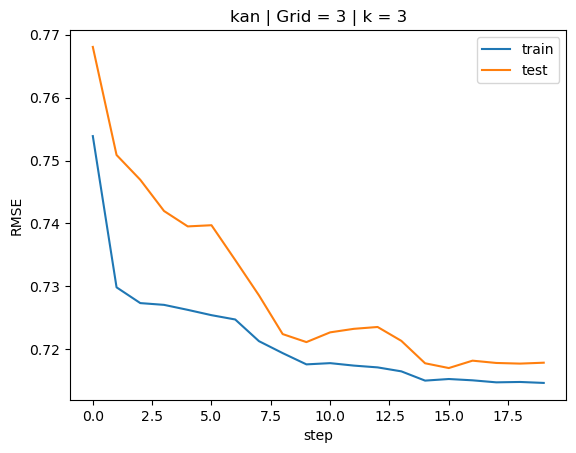

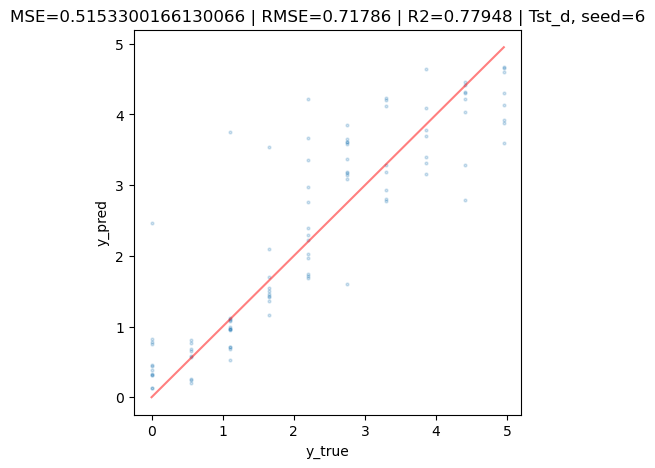

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.13e-01 | test_loss: 7.21e-01 | reg: 1.00e+01 | : 100%|█| 20/20 [00:07<00:00,  2.82it


saving model version 0.1


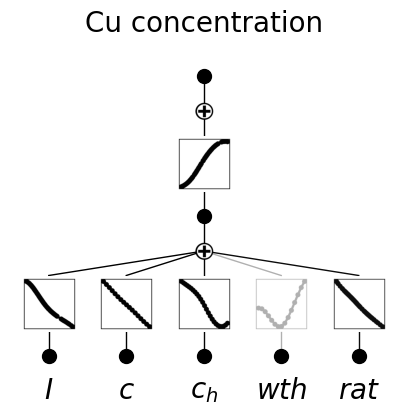

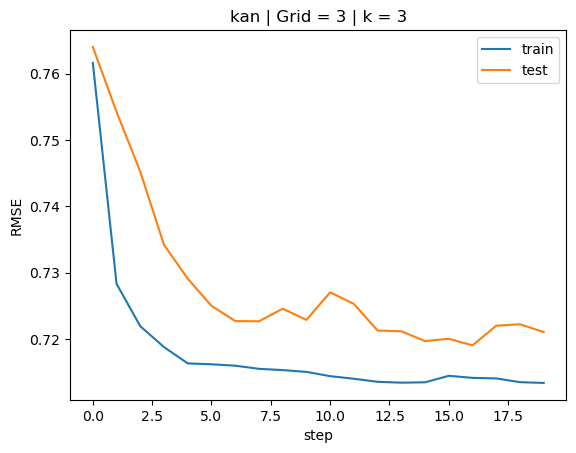

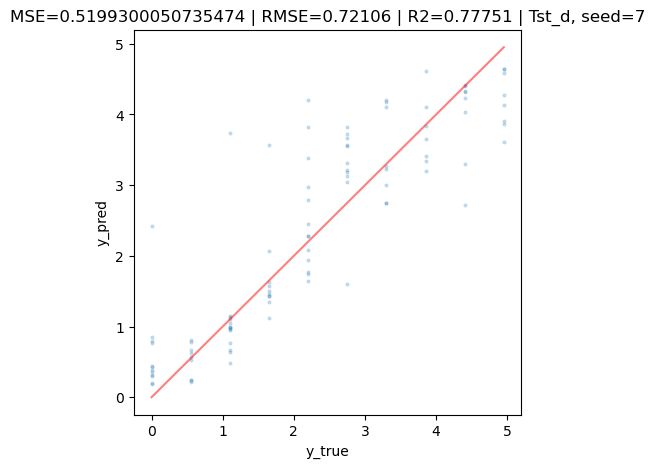

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.14e-01 | test_loss: 7.23e-01 | reg: 9.98e+00 | : 100%|█| 20/20 [00:07<00:00,  2.59it


saving model version 0.1


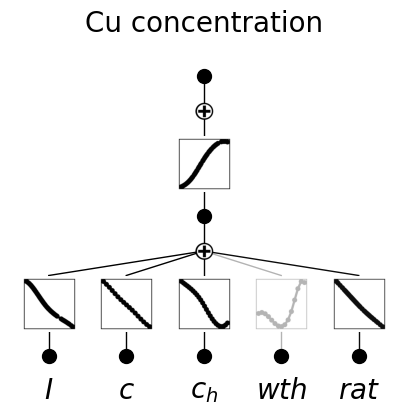

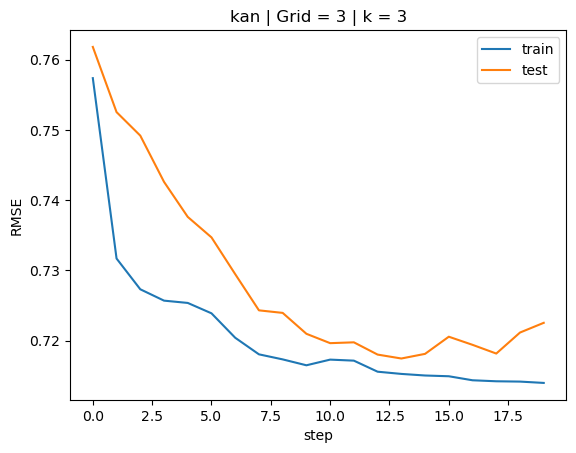

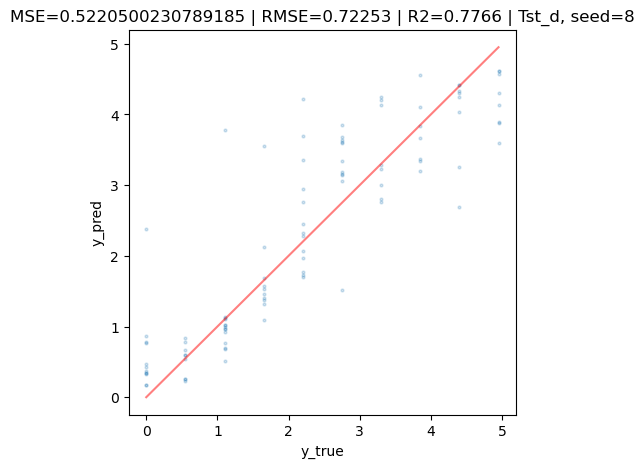

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.13e-01 | test_loss: 7.19e-01 | reg: 1.00e+01 | : 100%|█| 20/20 [00:06<00:00,  2.95it


saving model version 0.1


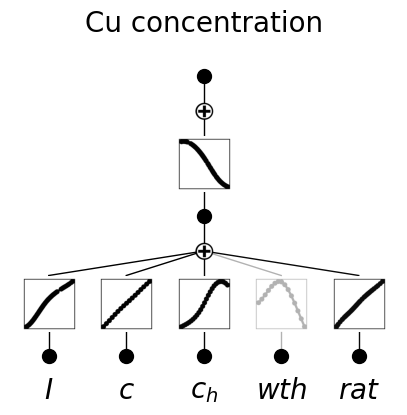

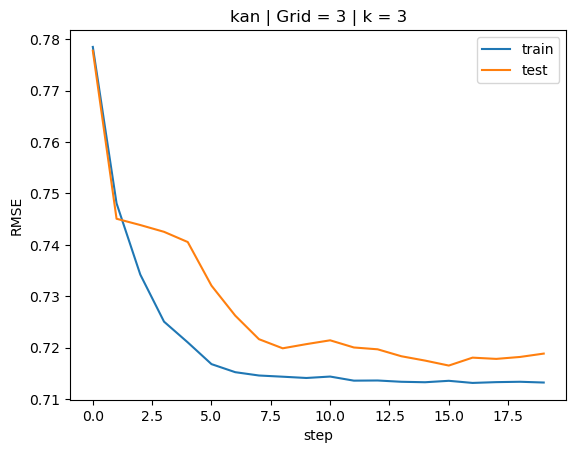

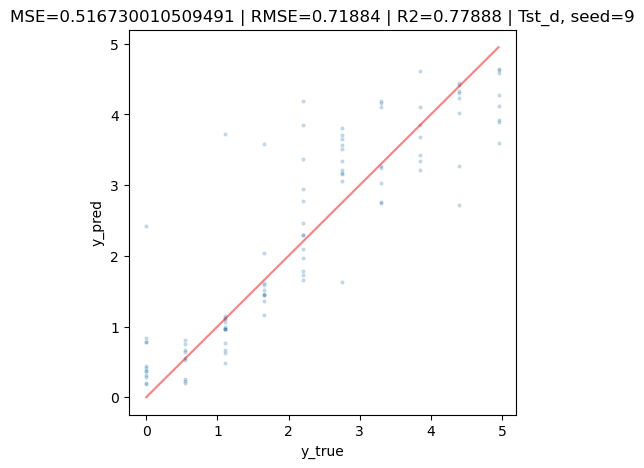

In [7]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)
    result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                           lamb=1e-2,
                           lamb_l1=1,
                           lamb_entropy=2
                           )

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    INPUT_SHAPE = tc_x_test.shape[1]
    prnt_kwrgs = {'in_vars': VAR, 
                    'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                    'title': None,
                    'sample': True,
                    'scale': 0.5}
    
    model2.plot(**prnt_kwrgs)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    #scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
    scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Tst_d, seed={seed}")

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 7.30e-01 | test_loss: 7.00e-01 | reg: 8.50e+00 | : 100%|█| 20/20 [00:04<00:00,  4.25it


saving model version 0.1


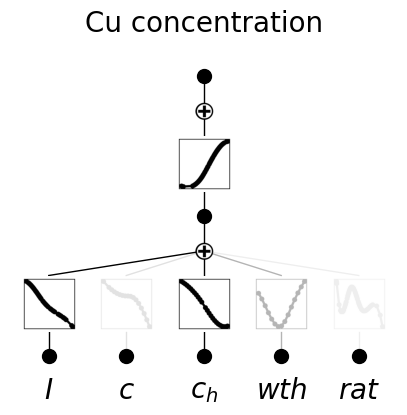

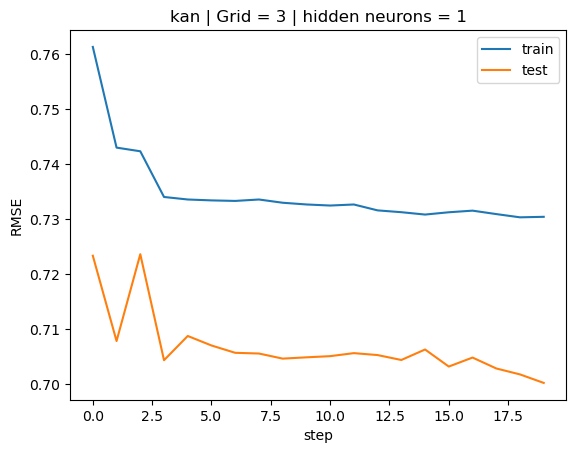

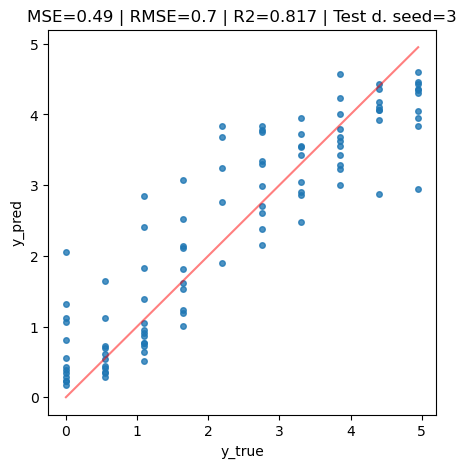

(0.49035218, 0.8172821998596191)

In [84]:
# Choose seed and train again
seed = 3
print(f'==========\n- {seed=} -\n==========')

model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)

result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
INPUT_SHAPE = tc_x_test.shape[1]
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }
model2.plot(**prnt_kwrgs)
plt.show()

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

#scatter_prediction_kan(model2, tc_x_train, tc_y_train, f"Train d. seed={seed}")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Test d. seed={seed}")

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      sin    0.996990 -8.371333           2                2   -0.074267
1      cos    0.996990 -8.371276           2                2   -0.074255
2        0    0.000000  0.000014           0                0    0.000003
3        x    0.405351 -0.749866           1                1    0.650027
4      x^2    0.954176 -4.447427           2                2    0.710515


('sin',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9969902038574219,
 2)

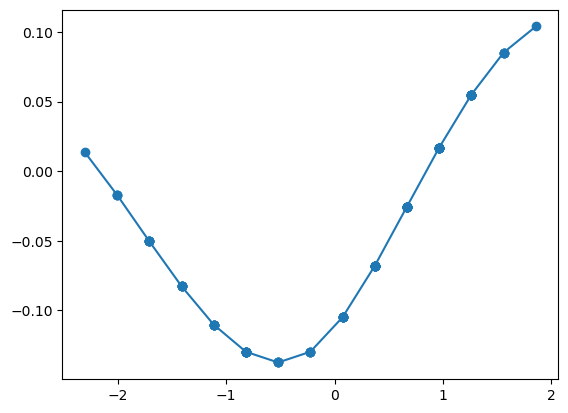

In [61]:
# suggest activation function
l = 0#1
i = 3#0
j = 0#0

inputs = model2.spline_preacts[l][:,j,i]
outputs = model2.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

model2.suggest_symbolic(l,i,j)

In [86]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 1#0
j = 0#0

model2.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2(dataset['train_input'])

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3


| train_loss: 7.33e-01 | test_loss: 6.93e-01 | reg: 8.46e+00 | : 100%|█| 20/20 [00:05<00:00,  3.58it

saving model version 0.4


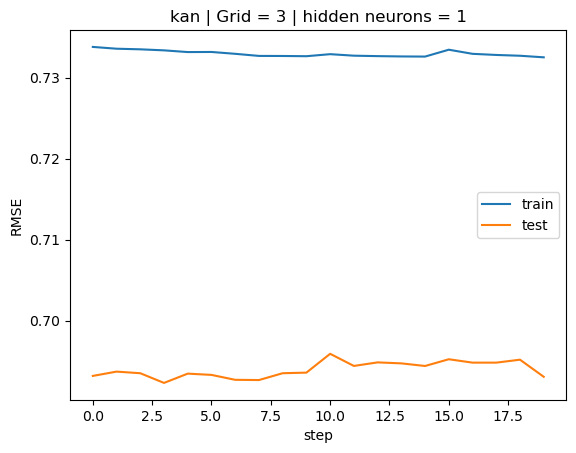

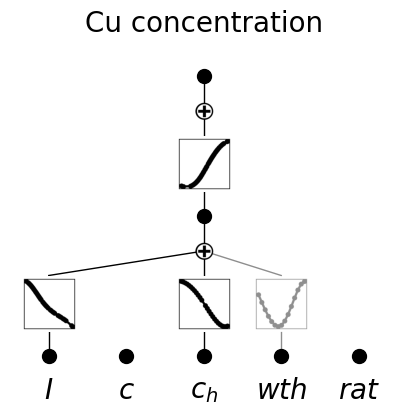

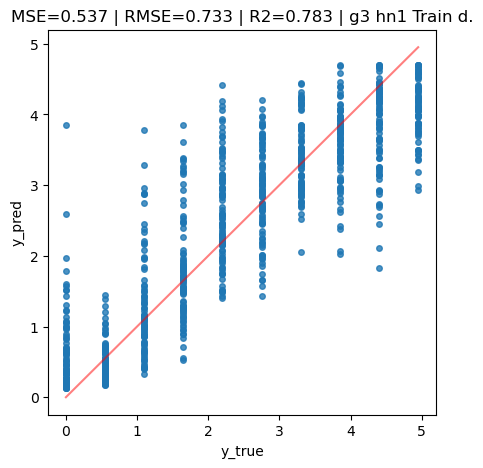

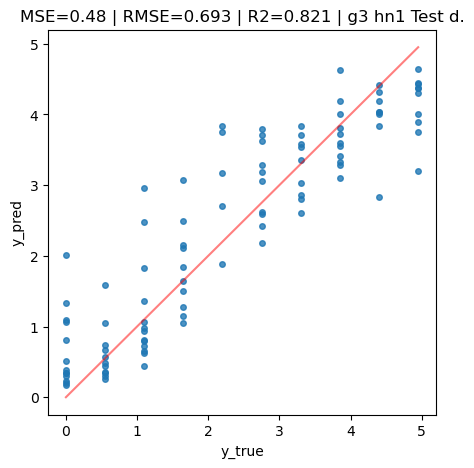

(0.48033482, 0.821014940738678)

In [87]:
# POSTFITTING reduced KAN
result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-3,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

model2.plot(**prnt_kwrgs)

scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 7.13e-01 | test_loss: 7.19e-01 | reg: 1.01e+01 | : 100%|█| 20/20 [00:06<00:00,  3.03it


saving model version 0.1


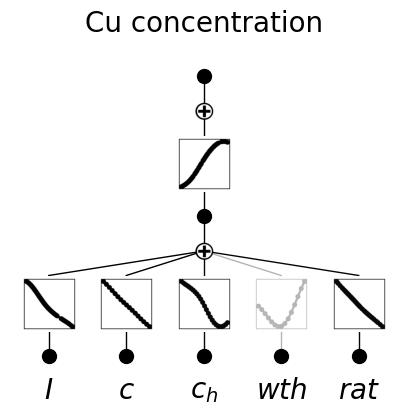

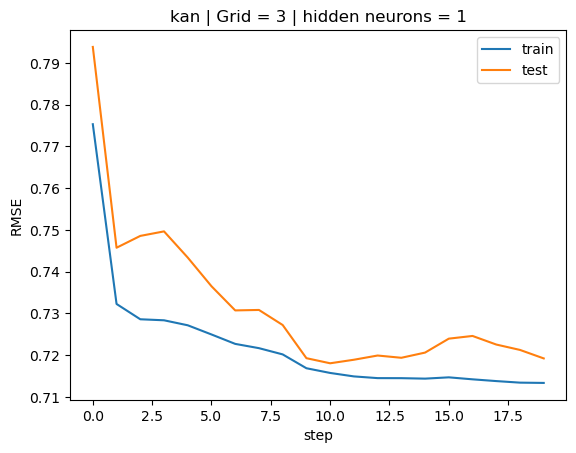

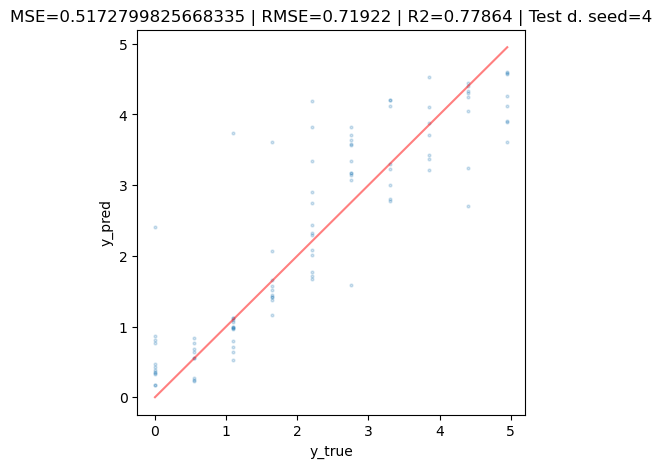

(0.517279, 0.7786418795585632)

In [8]:
# Choose seed and train again
seed = 4
print(f'==========\n- {seed=} -\n==========')

model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)

result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
INPUT_SHAPE = tc_x_test.shape[1]
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }
model2.plot(**prnt_kwrgs)
plt.show()

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

#scatter_prediction_kan(model2, tc_x_train, tc_y_train, f"Train d. seed={seed}")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Test d. seed={seed}")

In [9]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 3#0
j = 0#0

model2.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2(dataset['train_input'])

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.2


| train_loss: 7.17e-01 | test_loss: 7.21e-01 | reg: 9.97e+00 | : 100%|█| 20/20 [00:09<00:00,  2.15it


saving model version 0.3


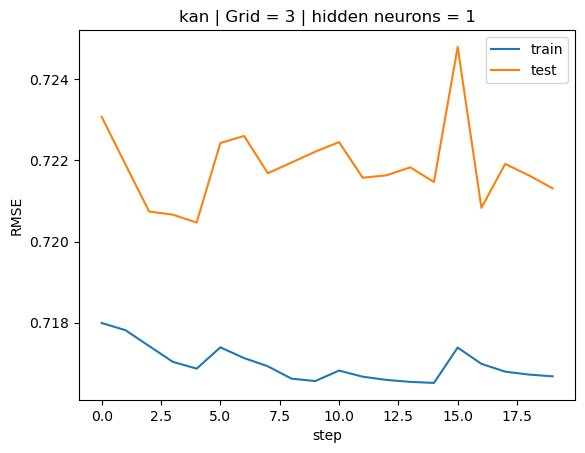

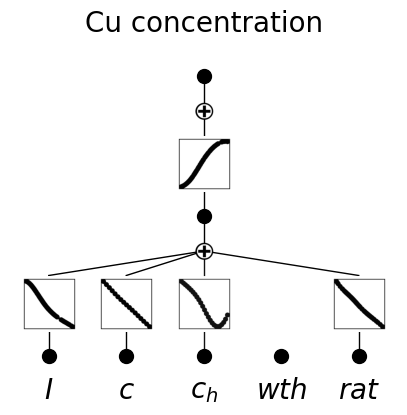

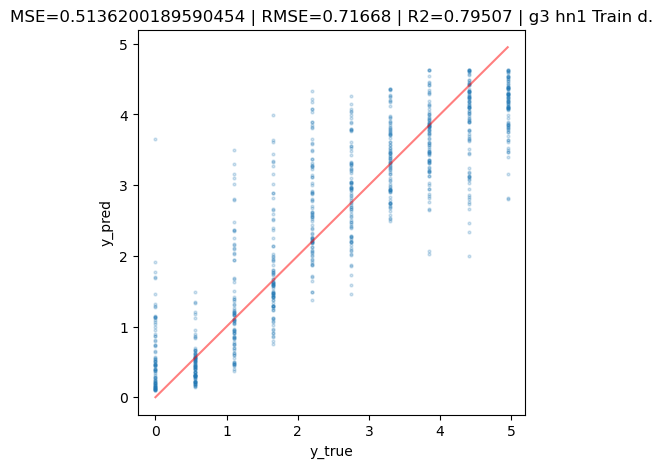

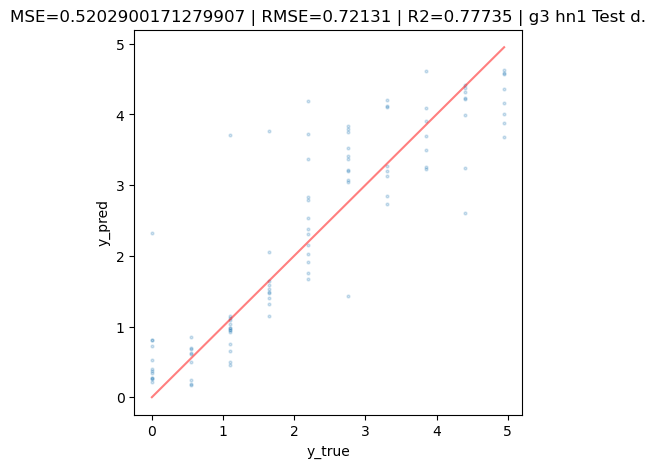

(0.52029, 0.7773534059524536)

In [10]:
# POSTFITTING reduced KAN
result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-3,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

model2.plot(**prnt_kwrgs)

scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")

# $Ni$

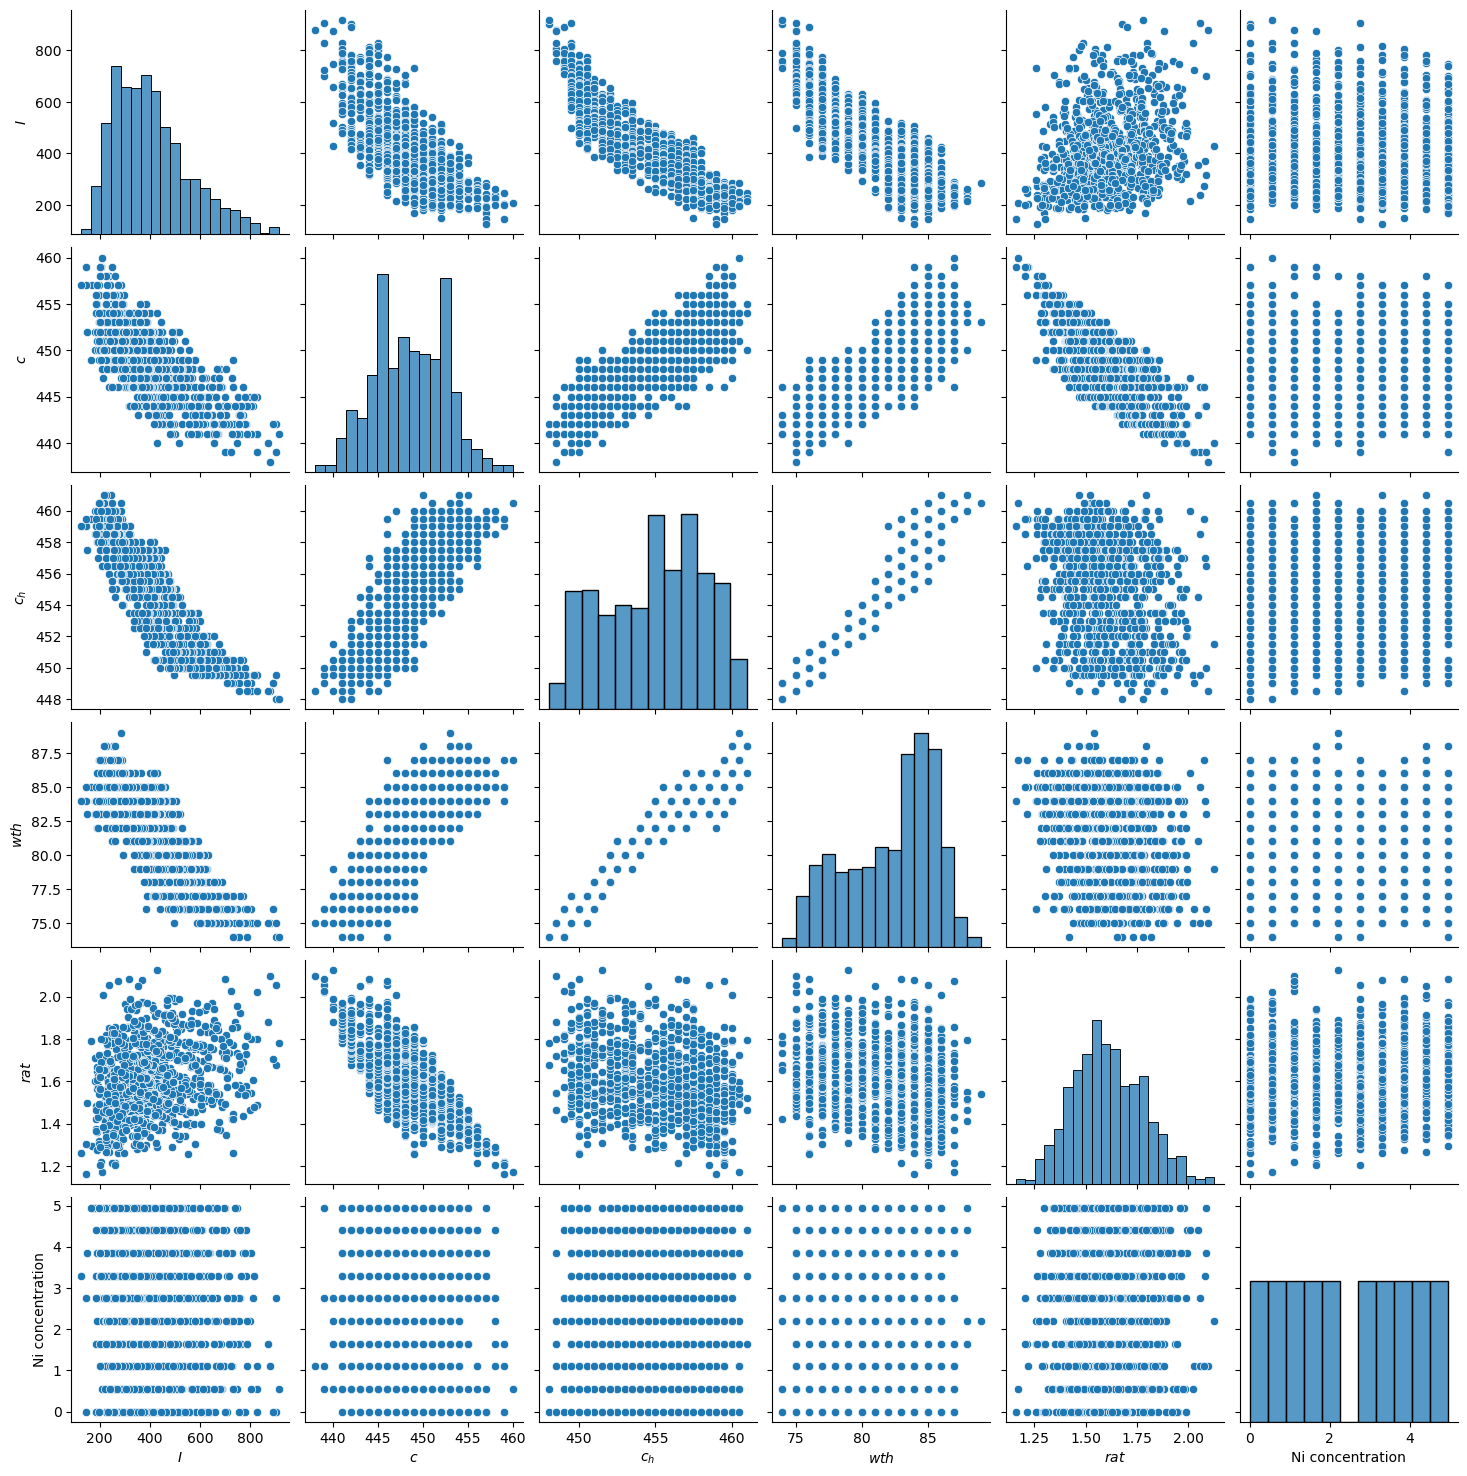

In [126]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Ni']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''

tc_x_train = torch.tensor(x_train, dtype=torch.float)
tc_y_train = torch.tensor(y_train.reshape([-1,1]), dtype=torch.float)
tc_x_test = torch.tensor(x_test, dtype=torch.float)
tc_y_test = torch.tensor(y_test.reshape([-1,1]), dtype=torch.float)

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

INPUT_SHAPE = tc_x_train.shape[1]

In [115]:
squeezed_df1 = squeezed_df.loc[:,['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration']]
squeezed_df1.columns = ['I', 'c', 'c_h', 'wth', 'rat', PREDICT_IONS[0] + ' concentration']


fig = px.scatter_matrix(
    squeezed_df1,
    dimensions=['I', 'c', 'c_h', 'wth', 'rat'],
    color=PREDICT_IONS[0] + ' concentration'
)
#fig.update_traces(diagonal_visible=False)

fig.update_layout(
    #title=dict(text='Iris Data set'),
    width=1000,
    height=800,
)

fig.show()

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | test_loss: 1.54e+00 | reg: 7.48e+00 | : 100%|█| 20/20 [00:07<00:00,  2.61it


saving model version 0.1


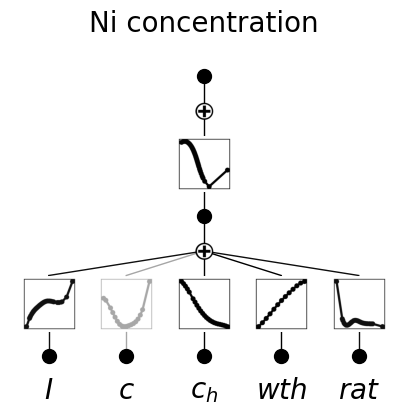

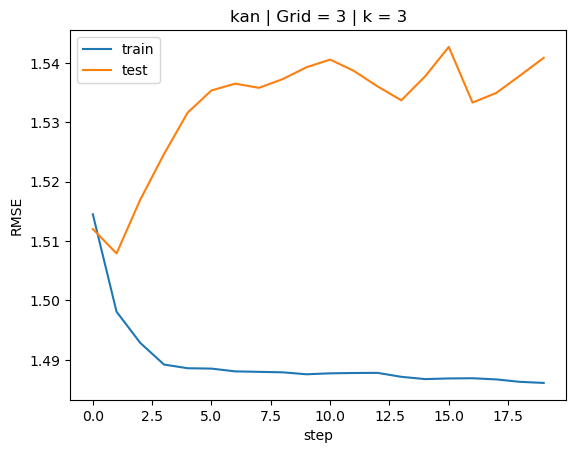

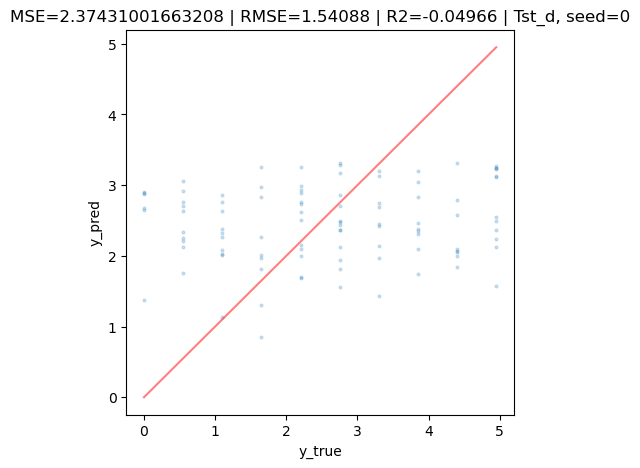

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | test_loss: 1.53e+00 | reg: 7.53e+00 | : 100%|█| 20/20 [00:06<00:00,  3.14it


saving model version 0.1


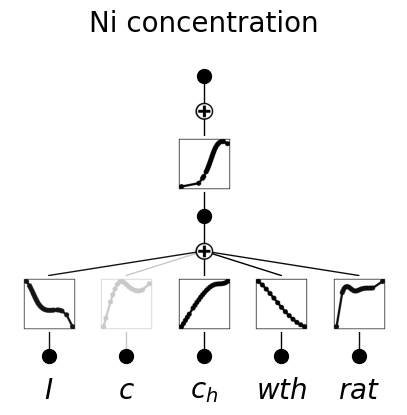

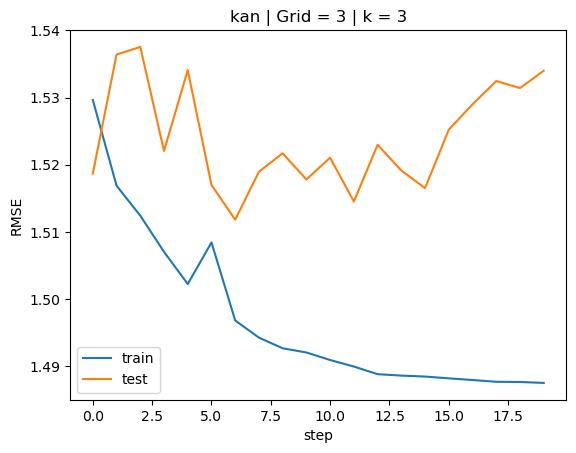

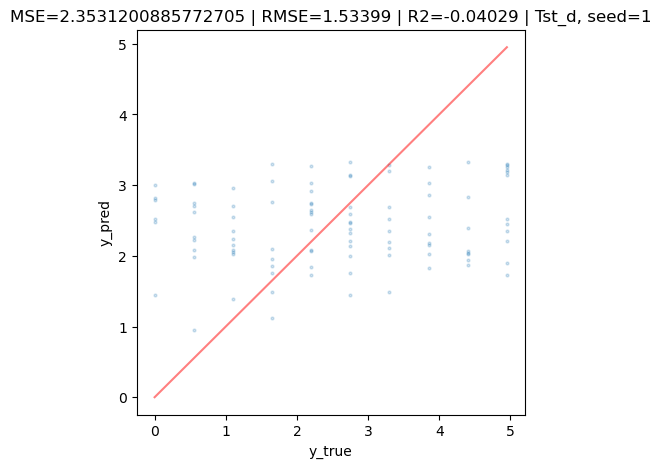

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | test_loss: 1.54e+00 | reg: 7.39e+00 | : 100%|█| 20/20 [00:07<00:00,  2.56it


saving model version 0.1


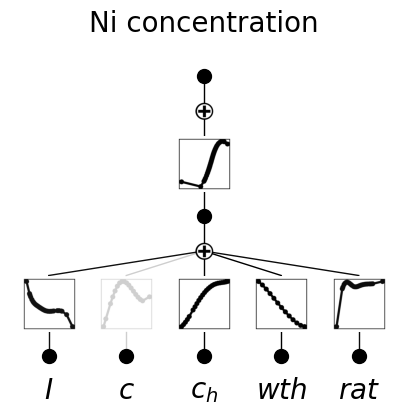

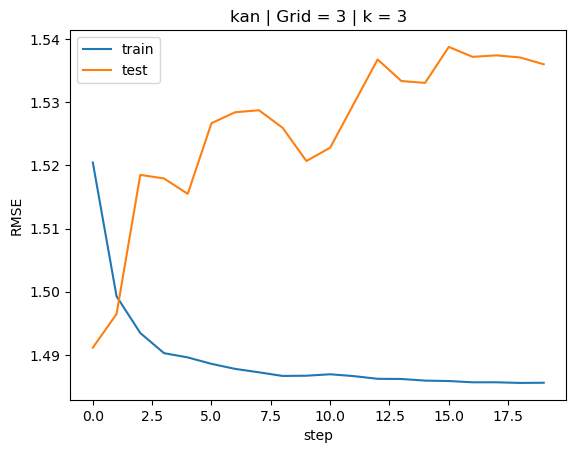

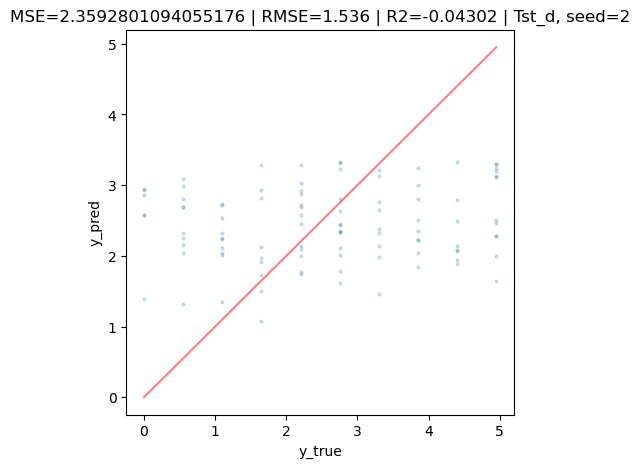

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | test_loss: 1.54e+00 | reg: 7.54e+00 | : 100%|█| 20/20 [00:08<00:00,  2.42it


saving model version 0.1


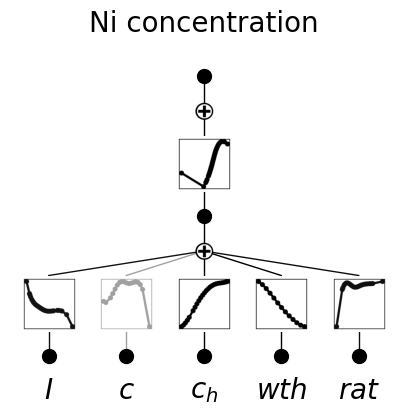

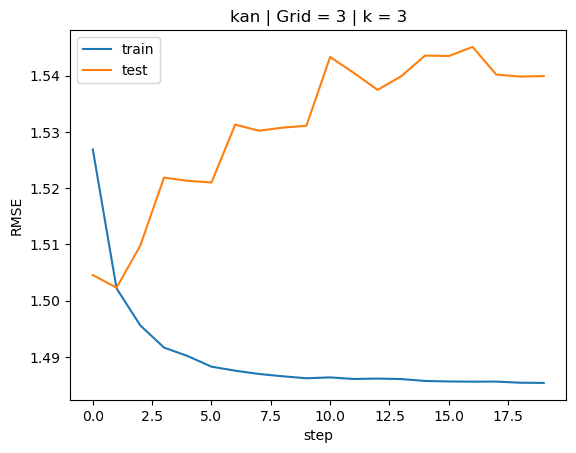

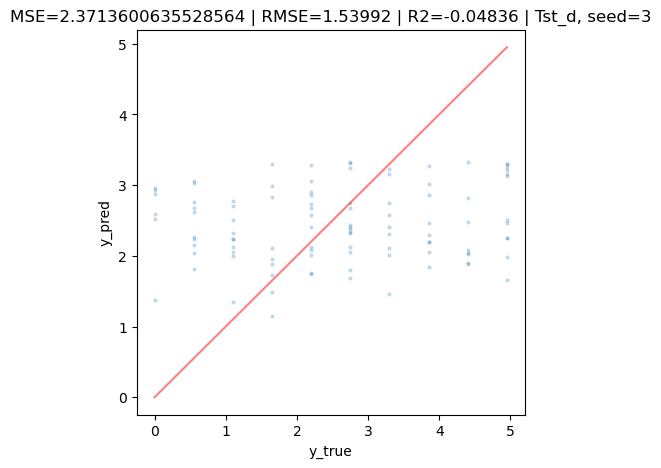

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e+00 | test_loss: 1.56e+00 | reg: 7.67e+00 | : 100%|█| 20/20 [00:07<00:00,  2.68it


saving model version 0.1


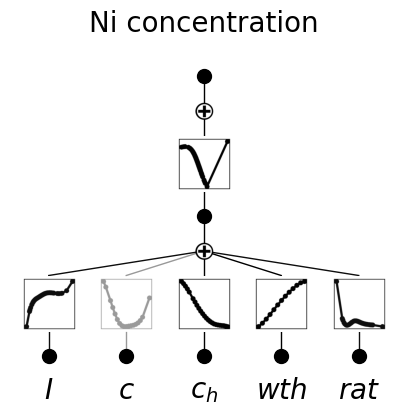

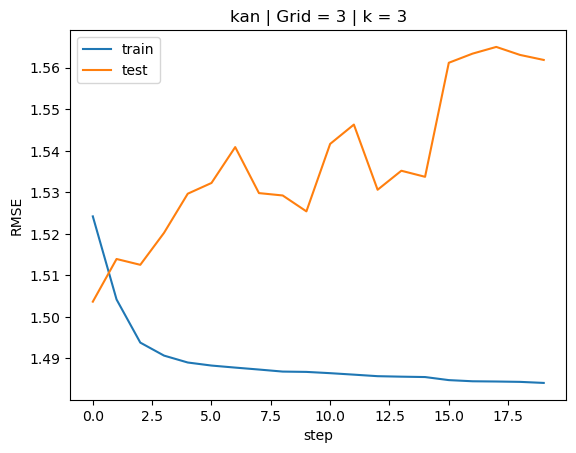

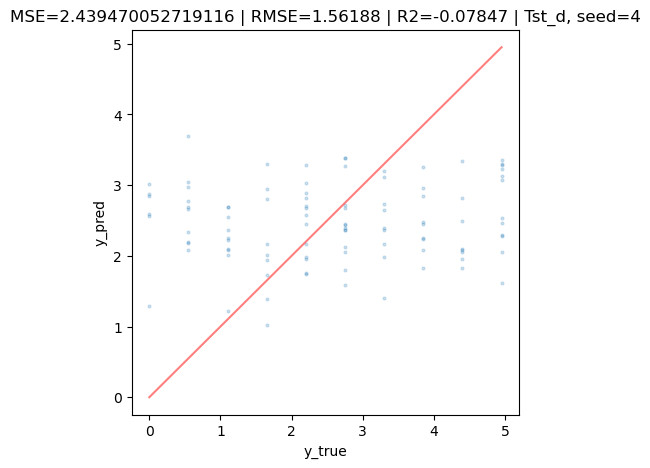

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | test_loss: 1.53e+00 | reg: 7.86e+00 | : 100%|█| 20/20 [00:07<00:00,  2.69it


saving model version 0.1


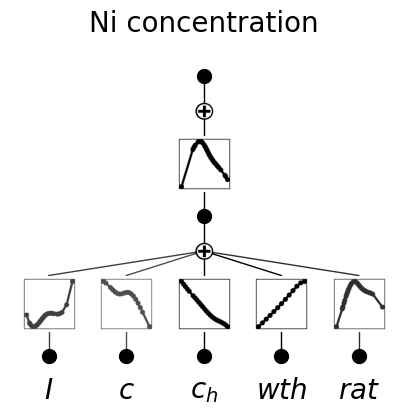

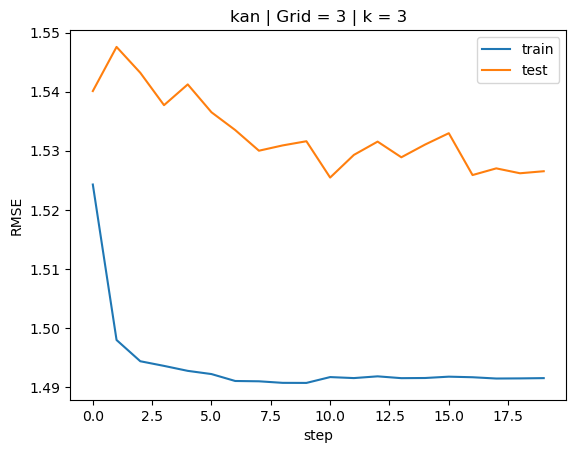

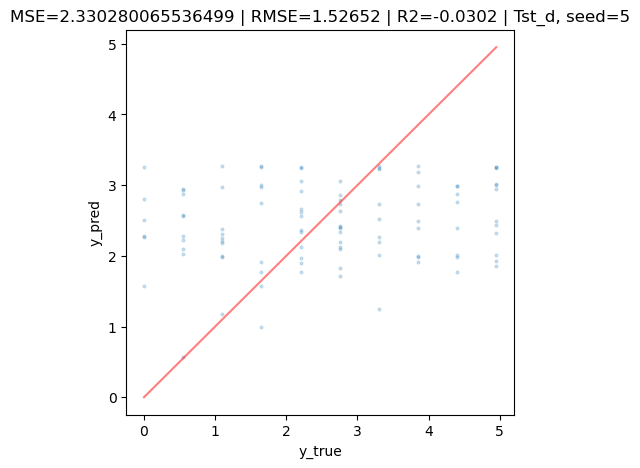

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | test_loss: 1.53e+00 | reg: 8.37e+00 | : 100%|█| 20/20 [00:06<00:00,  2.99it


saving model version 0.1


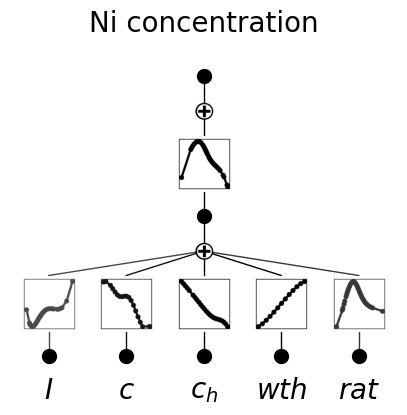

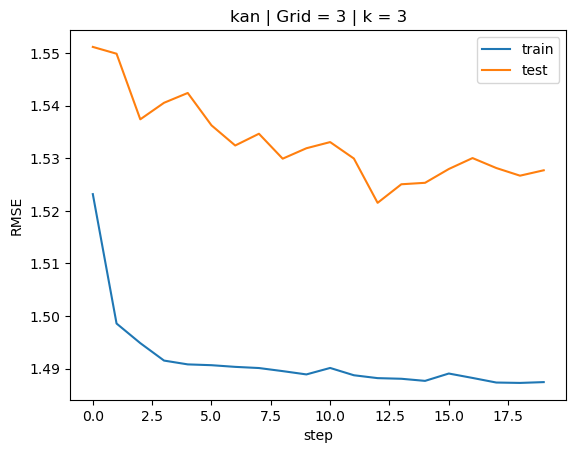

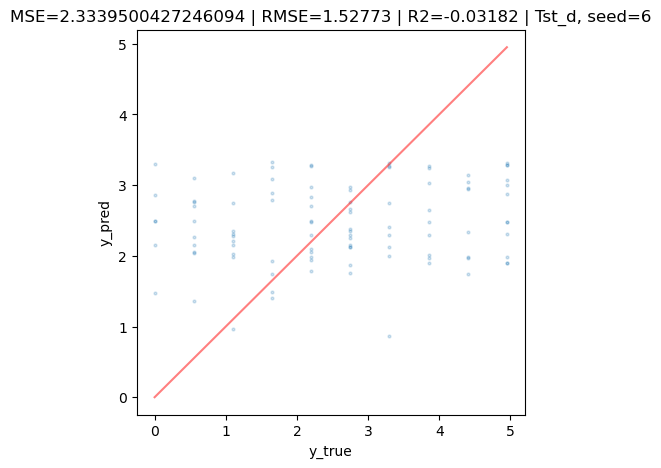

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | test_loss: 1.54e+00 | reg: 7.35e+00 | : 100%|█| 20/20 [00:07<00:00,  2.70it


saving model version 0.1


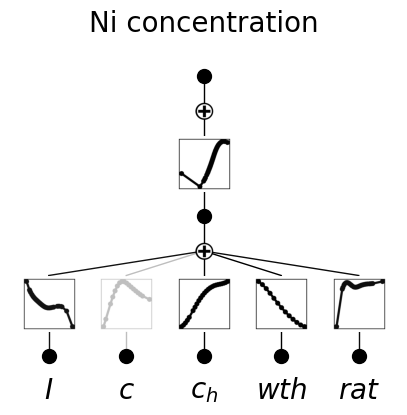

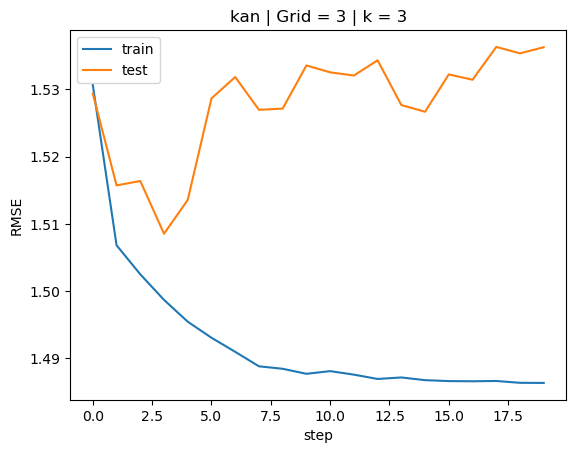

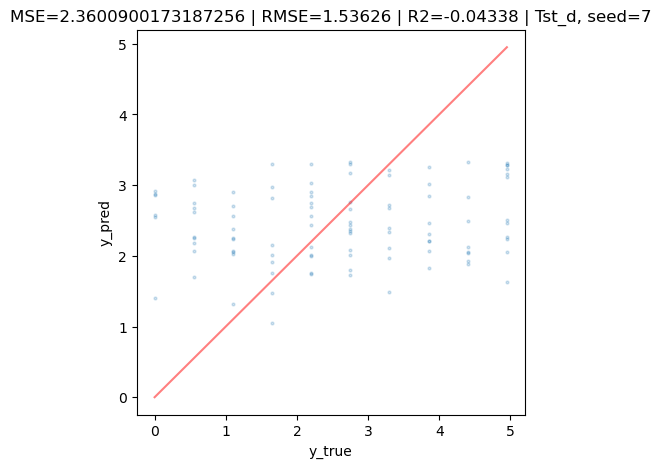

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e+00 | test_loss: 1.81e+00 | reg: 8.99e+00 | : 100%|█| 20/20 [00:06<00:00,  3.12it


saving model version 0.1


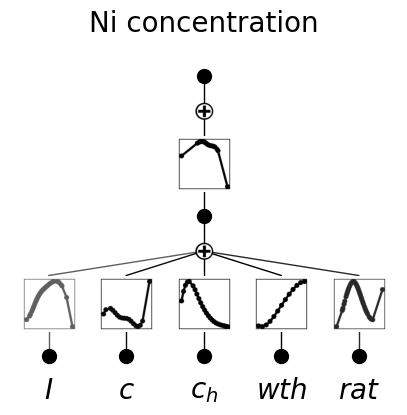

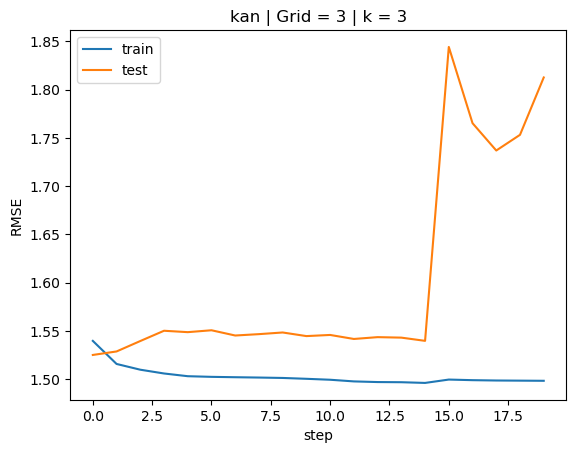

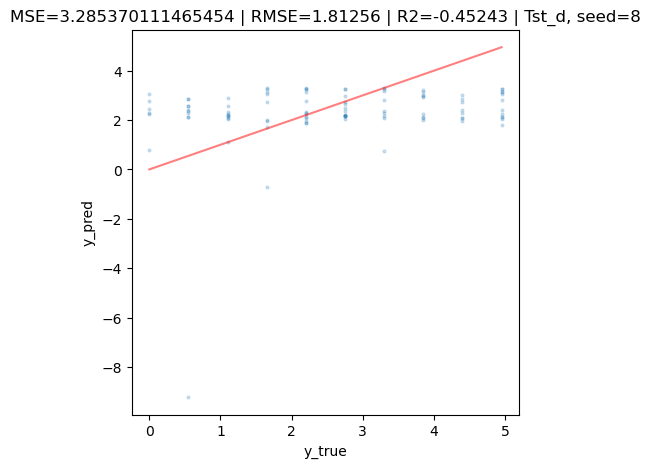

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | test_loss: 1.52e+00 | reg: 7.13e+00 | : 100%|█| 20/20 [00:07<00:00,  2.54it


saving model version 0.1


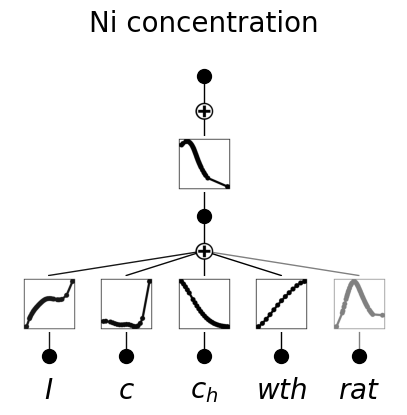

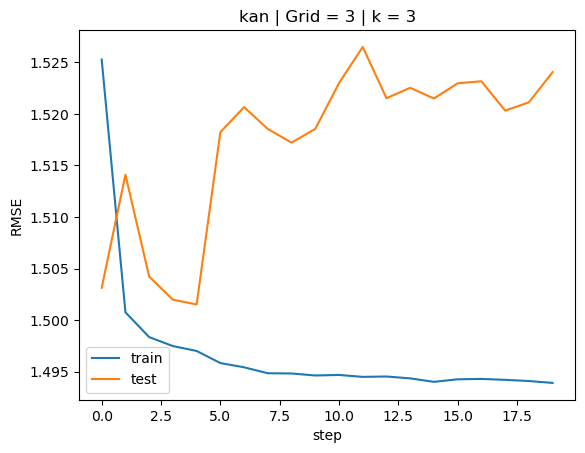

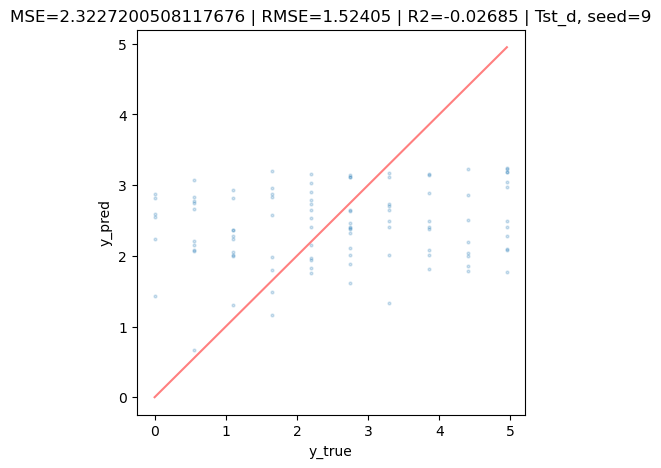

In [25]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)
    result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                           lamb=1e-2,
                           lamb_l1=1,
                           lamb_entropy=2
                           )

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    INPUT_SHAPE = tc_x_test.shape[1]
    prnt_kwrgs = {'in_vars': VAR, 
                    'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                    'title': None,
                    'sample': True,
                    'scale': 0.5}
    
    model2.plot(**prnt_kwrgs)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    #scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
    scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Tst_d, seed={seed}")

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 1.46e+00 | test_loss: 1.69e+00 | reg: 8.83e+00 | : 100%|█| 20/20 [00:04<00:00,  4.02it


saving model version 0.1


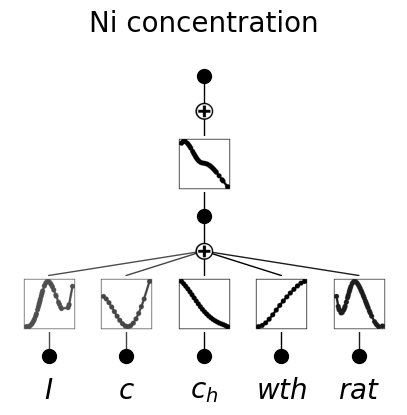

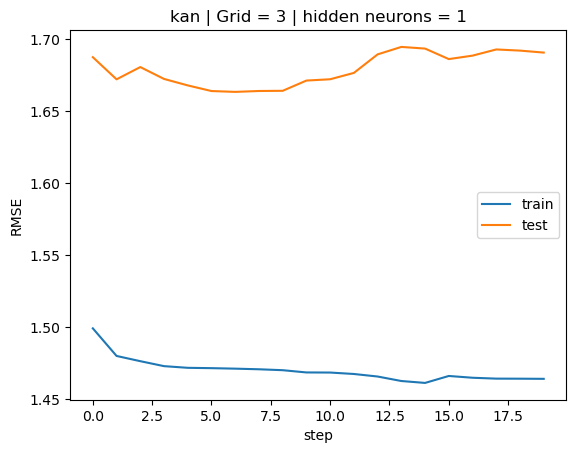

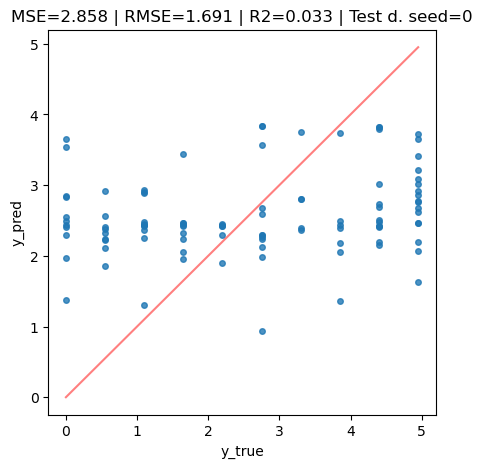

(2.8580697, 0.033099591732025146)

In [113]:
# Choose seed and train again
seed = 0
print(f'==========\n- {seed=} -\n==========')

model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)

result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
INPUT_SHAPE = tc_x_test.shape[1]
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }
model2.plot(**prnt_kwrgs)
plt.show()

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

#scatter_prediction_kan(model2, tc_x_train, tc_y_train, f"Train d. seed={seed}")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Test d. seed={seed}")

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1      x^2    0.963553 -4.777666           2                2    0.644467
2      cos    0.959971 -4.642464           2                2    0.671507
3      sin    0.959971 -4.642464           2                2    0.671507
4        x    0.110958 -0.169661           1                1    0.766068


('0',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  0,
  <function kan.utils.<lambda>(x, y_th)>),
 0.0,
 0)

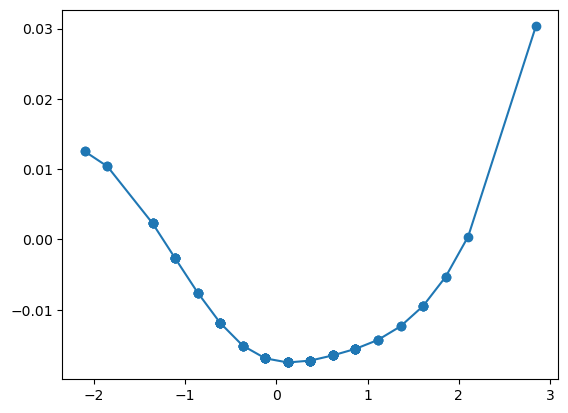

In [27]:
# suggest activation function
l = 0#1
i = 1#0
j = 0#0

inputs = model2.spline_preacts[l][:,j,i]
outputs = model2.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

model2.suggest_symbolic(l,i,j)

In [111]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 1#0
j = 0#0

model2.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2(dataset['train_input'])

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3


| train_loss: 1.46e+00 | test_loss: 1.69e+00 | reg: 9.81e+00 | : 100%|█| 20/20 [00:04<00:00,  4.28it

saving model version 0.2


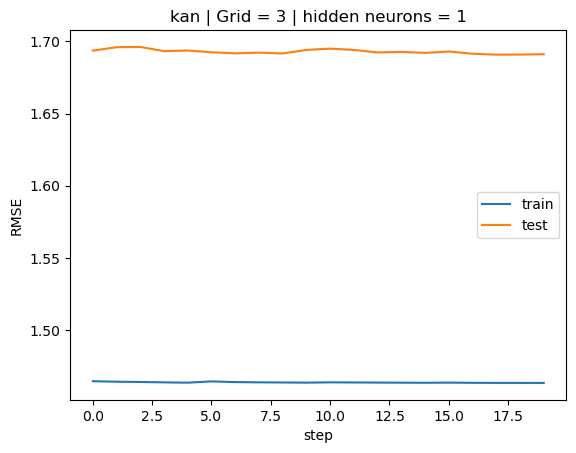

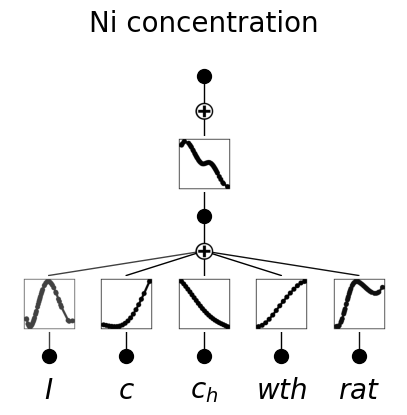

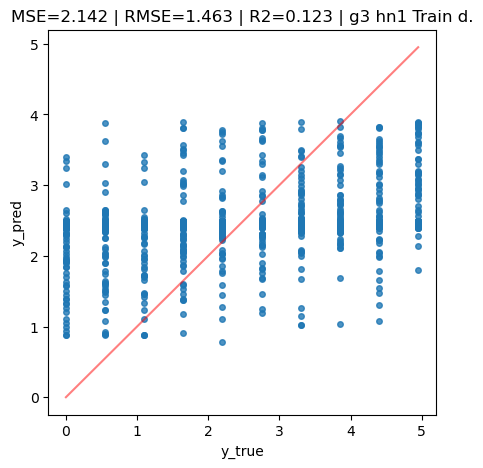

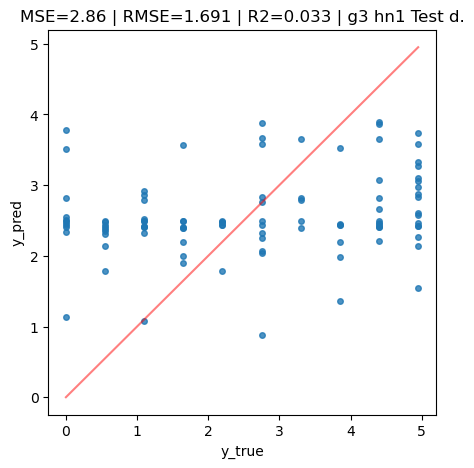

(2.8598185, 0.032508015632629395)

In [116]:
# POSTFITTING reduced KAN
result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-3,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

model2.plot(**prnt_kwrgs)

scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")

# $NO_3$

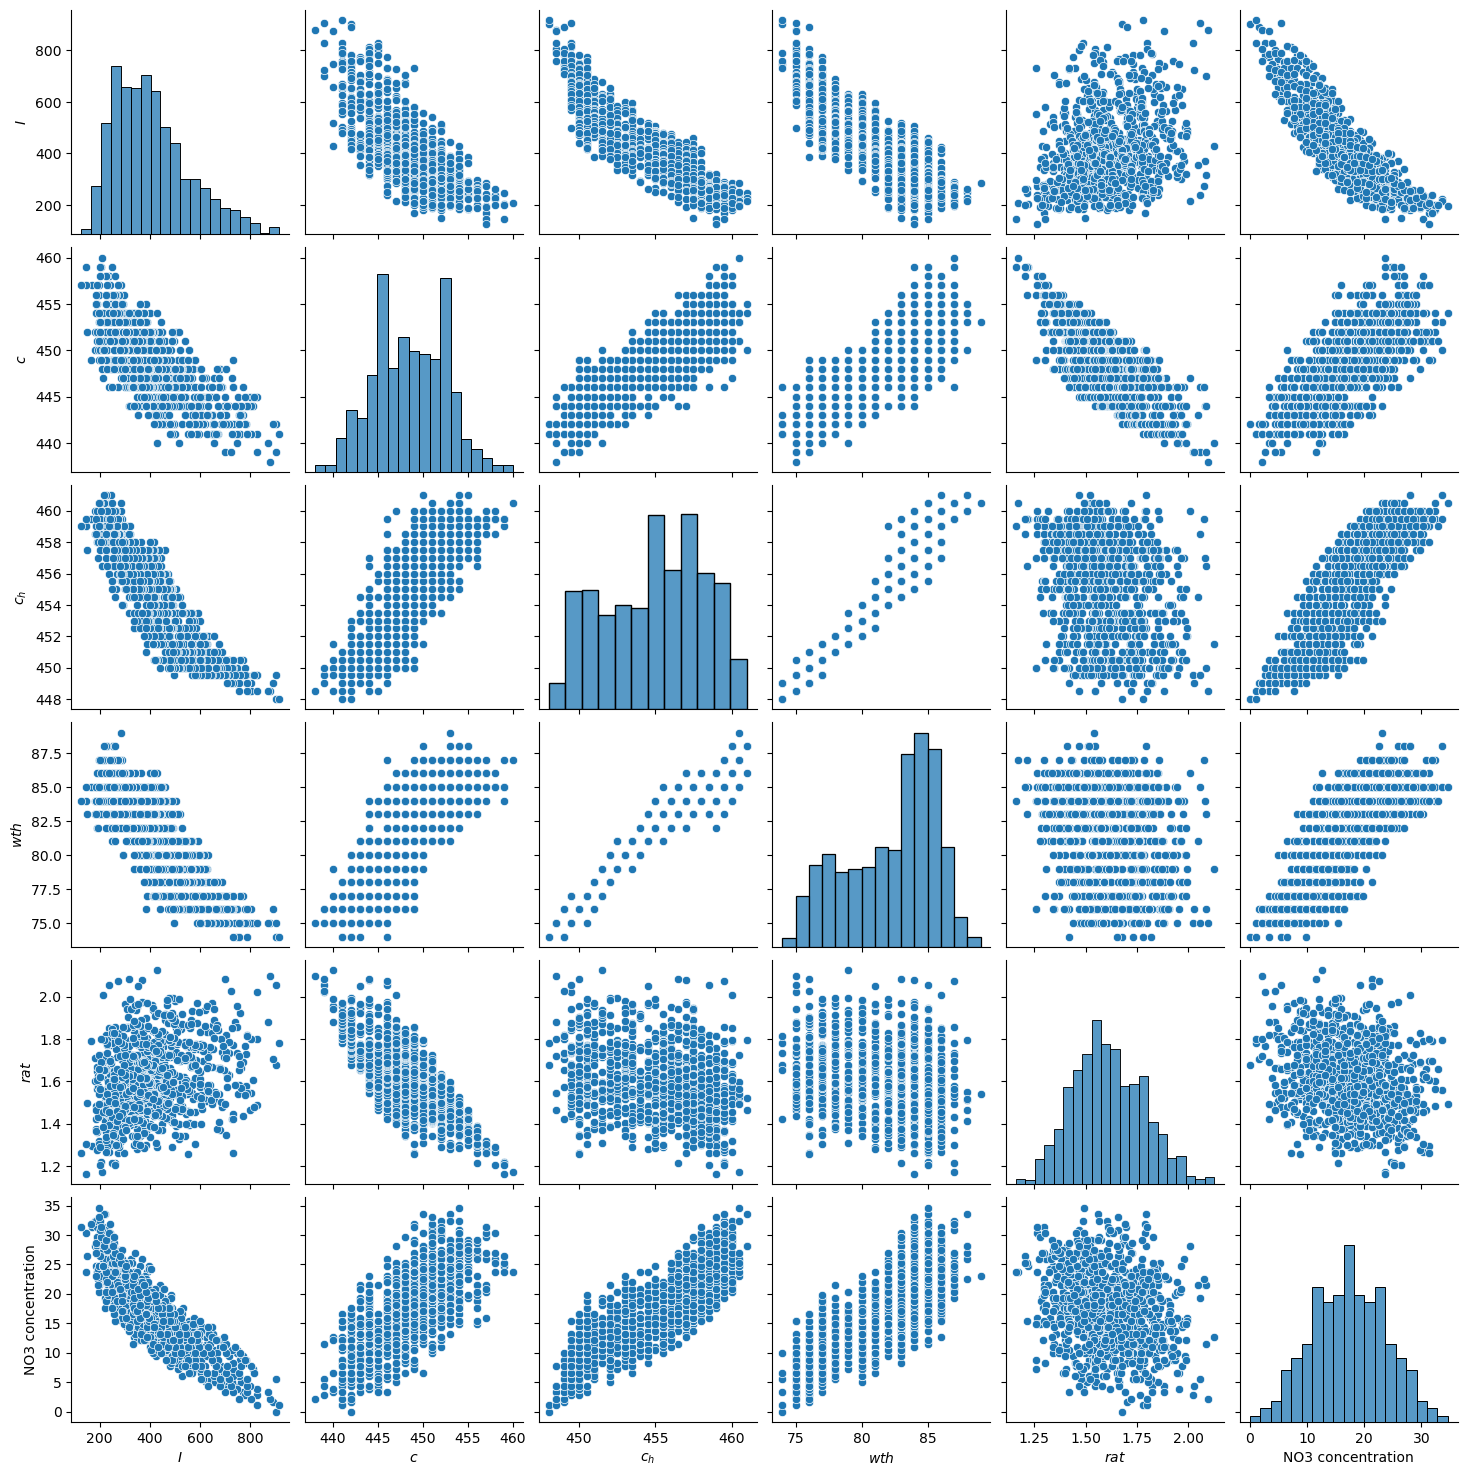

In [127]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['NO3']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''

tc_x_train = torch.tensor(x_train, dtype=torch.float)
tc_y_train = torch.tensor(y_train.reshape([-1,1]), dtype=torch.float)
tc_x_test = torch.tensor(x_test, dtype=torch.float)
tc_y_test = torch.tensor(y_test.reshape([-1,1]), dtype=torch.float)

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

INPUT_SHAPE = tc_x_train.shape[1]

In [129]:
squeezed_df1 = squeezed_df.loc[:,['$I$', '$c_h$', '$wth$', PREDICT_IONS[0] + ' concentration']]
squeezed_df1.columns = ['I', 'c_h', 'wth', PREDICT_IONS[0] + ' concentration']


fig = px.scatter_matrix(
    squeezed_df1,
    dimensions=['I', 'c_h', 'wth'],
    color=PREDICT_IONS[0] + ' concentration'
)
#fig.update_traces(diagonal_visible=False)

fig.update_layout(
    #title=dict(text='Iris Data set'),
    width=1000,
    height=800,
)

fig.show()

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 2.94e+00 | test_loss: 3.13e+00 | reg: 1.20e+01 | : 100%|█| 20/20 [00:07<00:00,  2.74it


saving model version 0.1


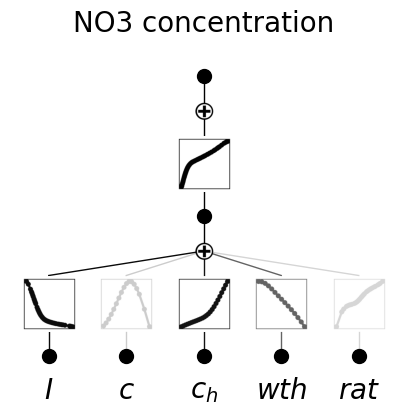

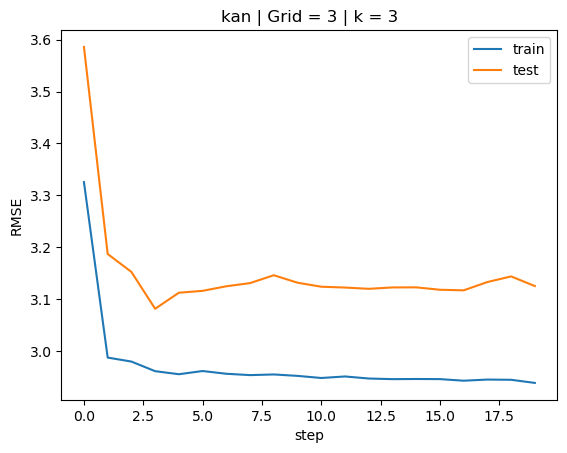

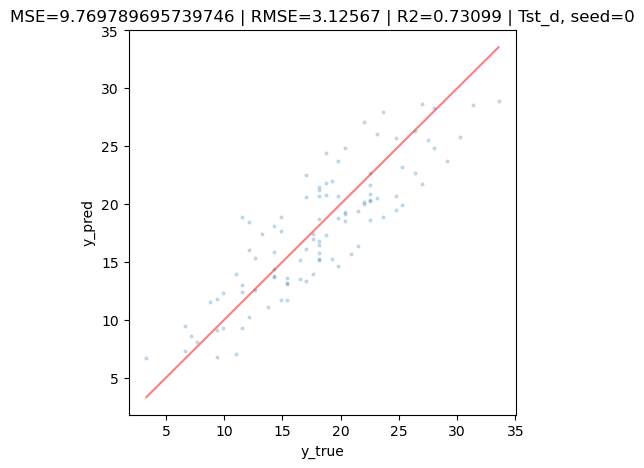

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.94e+00 | test_loss: 3.12e+00 | reg: 1.08e+01 | : 100%|█| 20/20 [00:06<00:00,  3.31it


saving model version 0.1


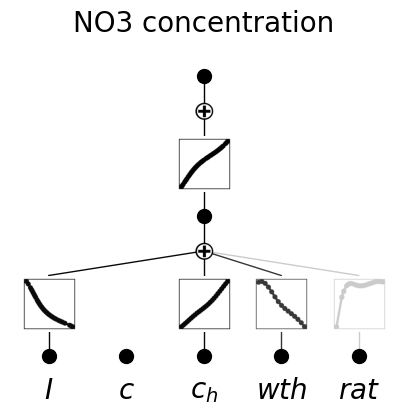

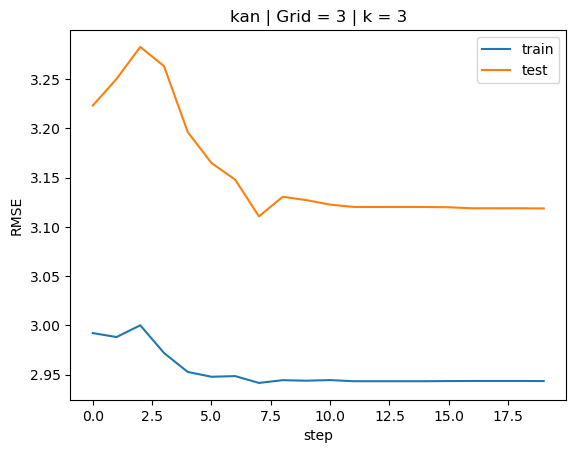

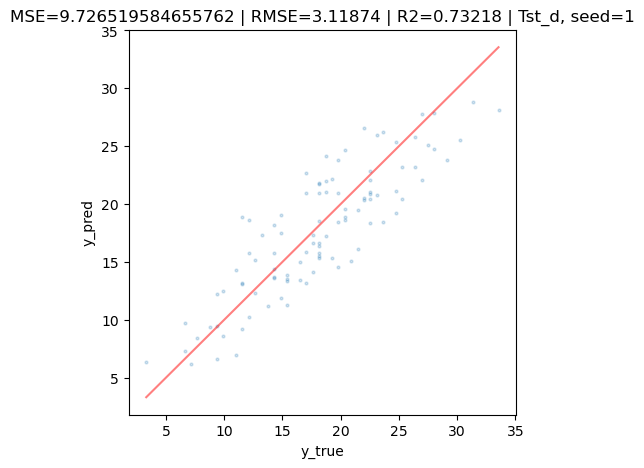

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.95e+00 | test_loss: 3.12e+00 | reg: 1.07e+01 | : 100%|█| 20/20 [00:06<00:00,  2.87it


saving model version 0.1


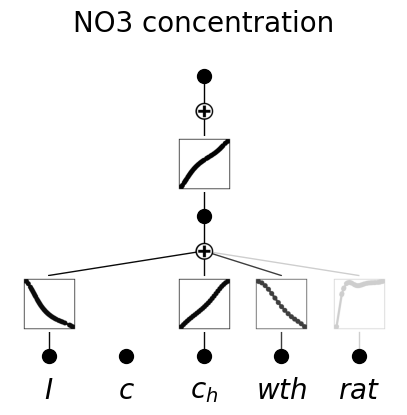

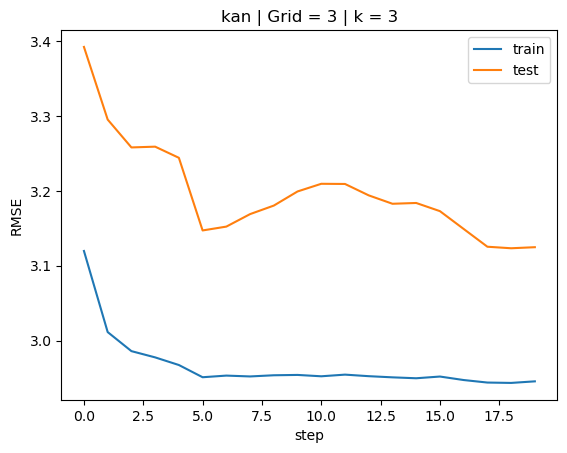

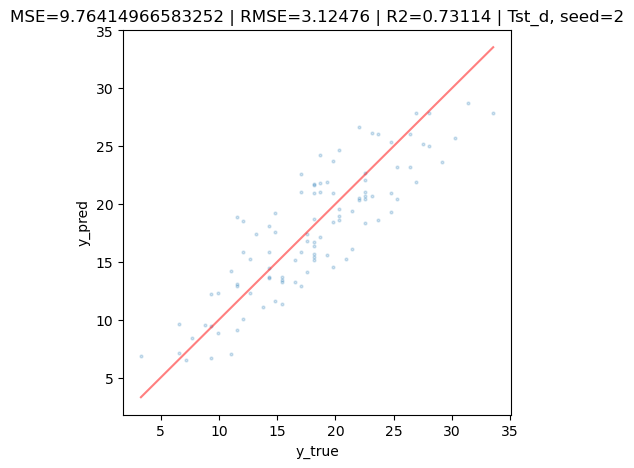

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.95e+00 | test_loss: 3.15e+00 | reg: 1.32e+01 | : 100%|█| 20/20 [00:07<00:00,  2.73it


saving model version 0.1


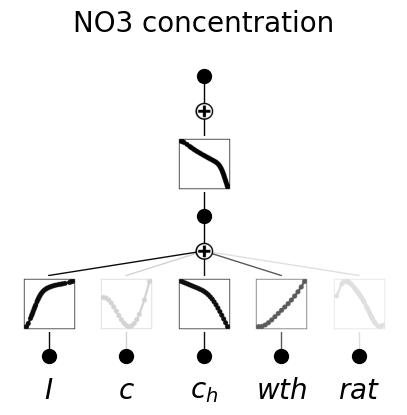

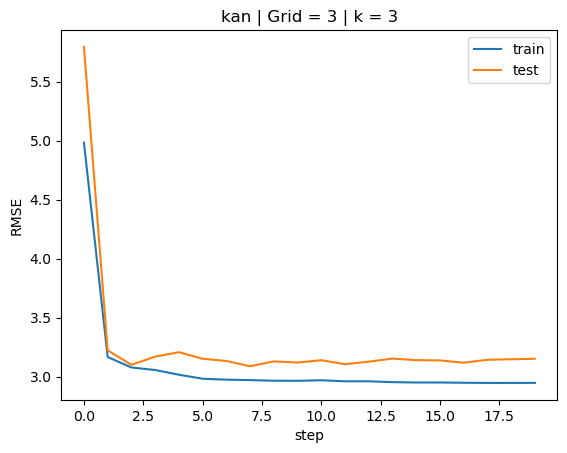

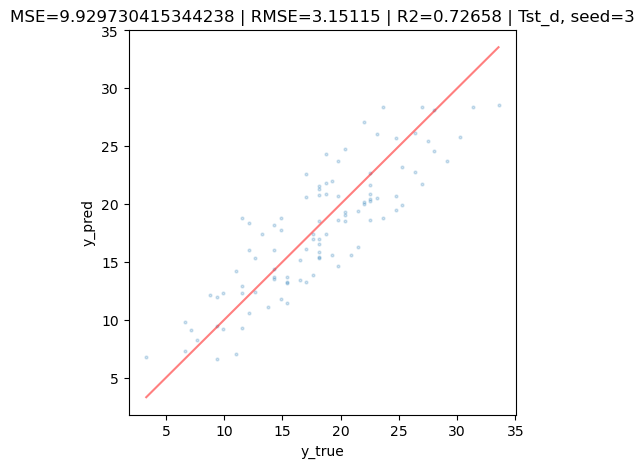

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.95e+00 | test_loss: 3.15e+00 | reg: 1.22e+01 | : 100%|█| 20/20 [00:07<00:00,  2.55it


saving model version 0.1


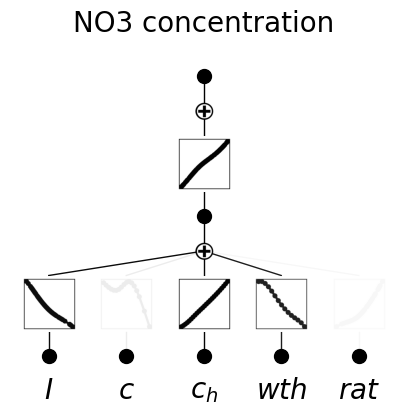

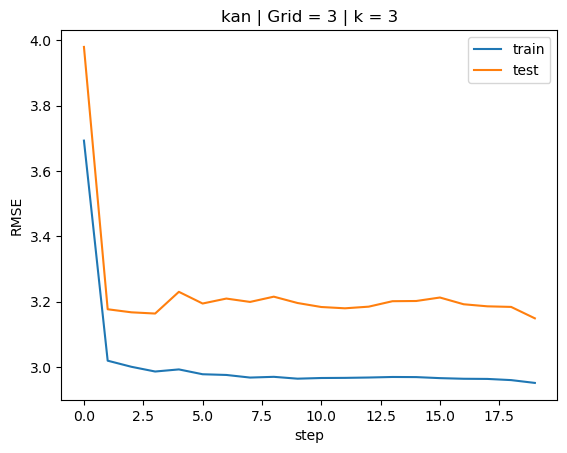

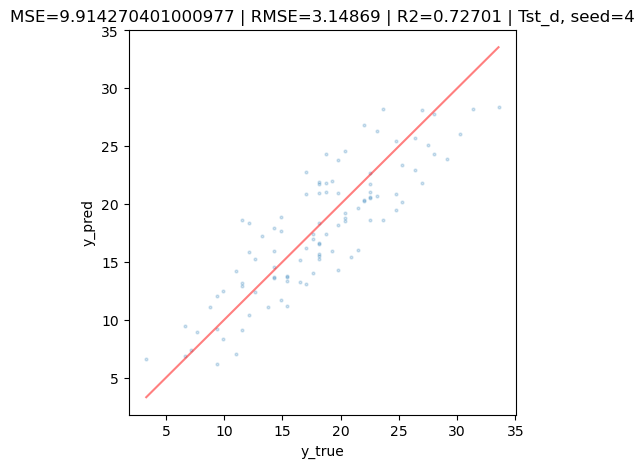

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.97e+00 | test_loss: 3.21e+00 | reg: 1.33e+01 | : 100%|█| 20/20 [00:07<00:00,  2.82it


saving model version 0.1


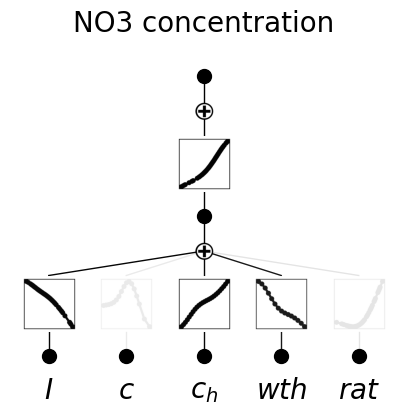

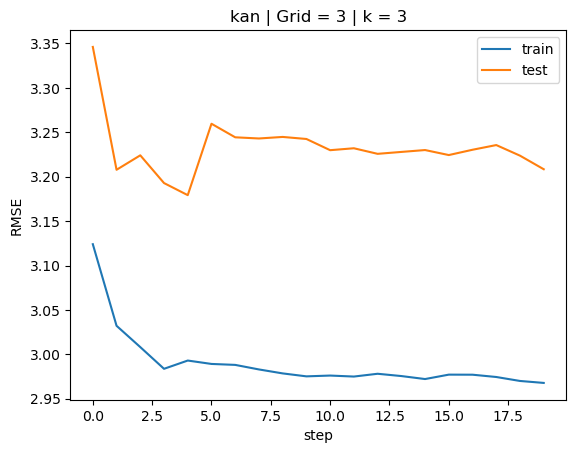

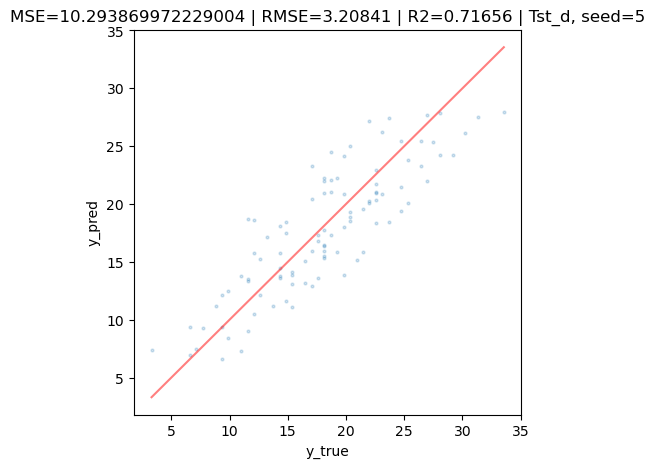

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.97e+00 | test_loss: 3.15e+00 | reg: 1.88e+01 | : 100%|█| 20/20 [00:07<00:00,  2.73it


saving model version 0.1


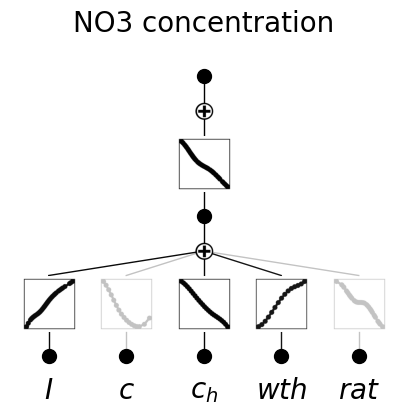

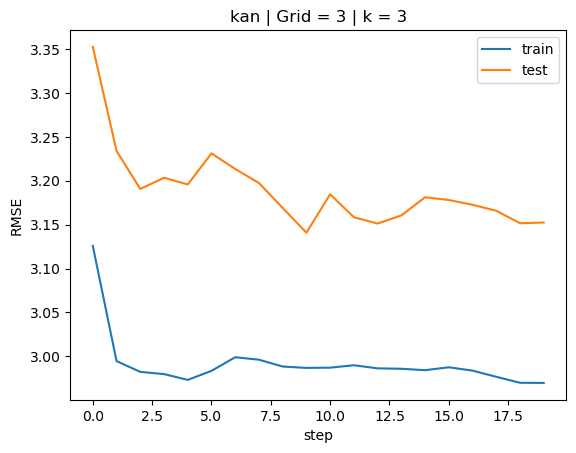

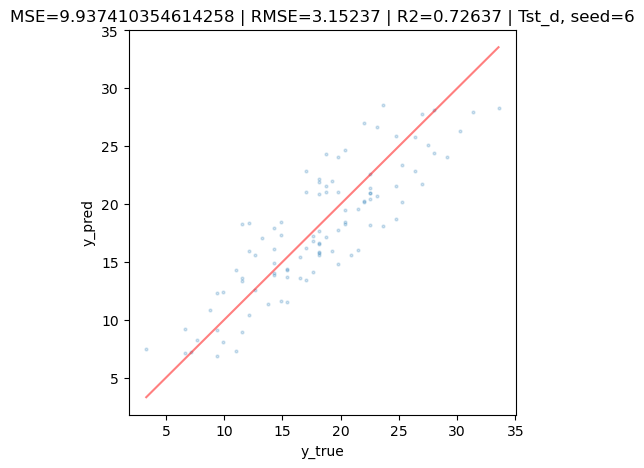

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.91e+00 | test_loss: 3.07e+00 | reg: 1.38e+01 | : 100%|█| 20/20 [00:06<00:00,  2.89it


saving model version 0.1


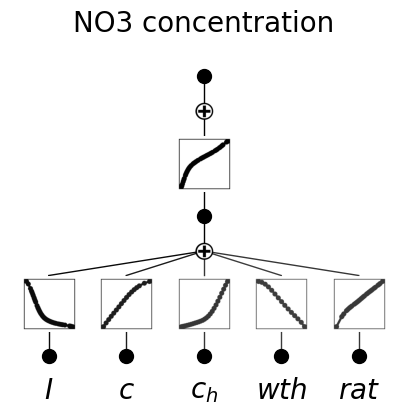

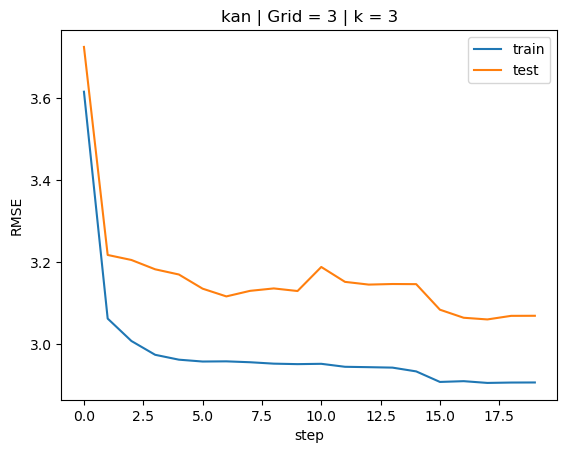

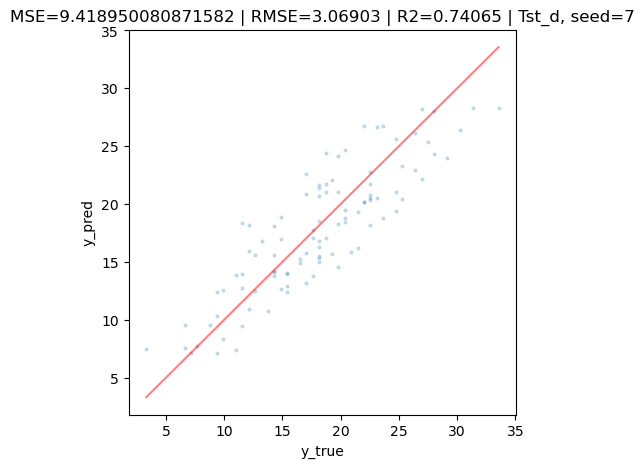

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.96e+00 | test_loss: 3.14e+00 | reg: 1.65e+01 | : 100%|█| 20/20 [00:06<00:00,  2.94it


saving model version 0.1


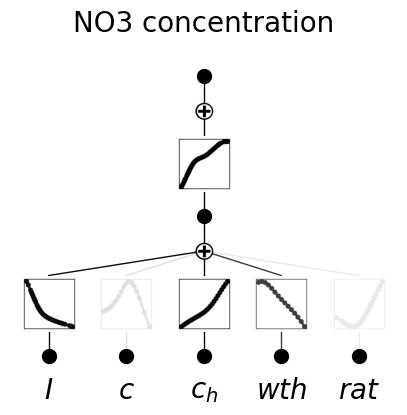

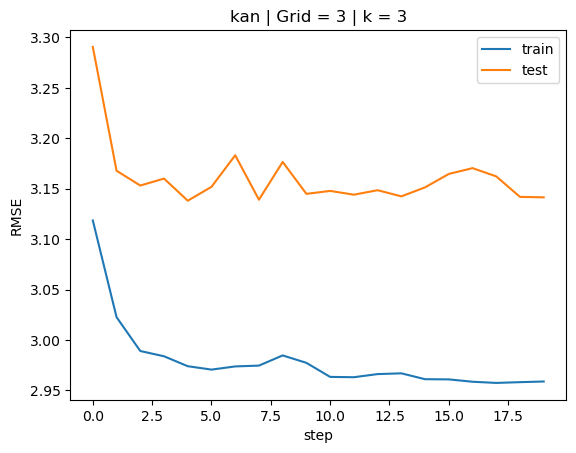

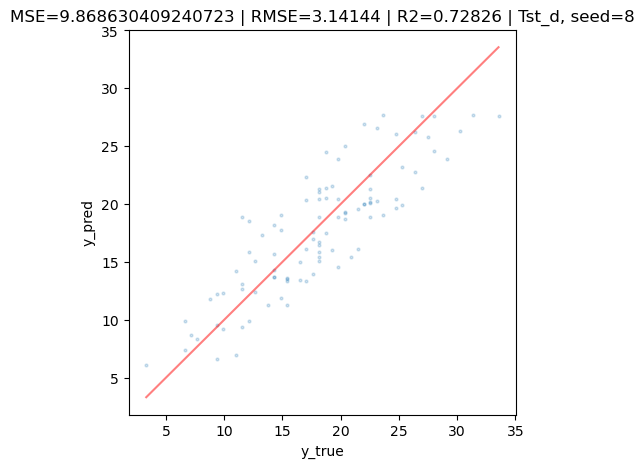

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.94e+00 | test_loss: 3.12e+00 | reg: 1.10e+01 | : 100%|█| 20/20 [00:07<00:00,  2.75it


saving model version 0.1


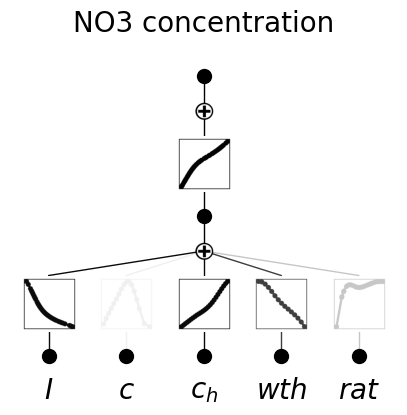

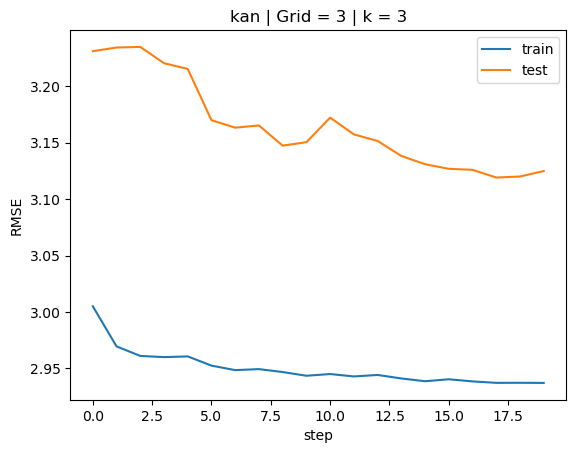

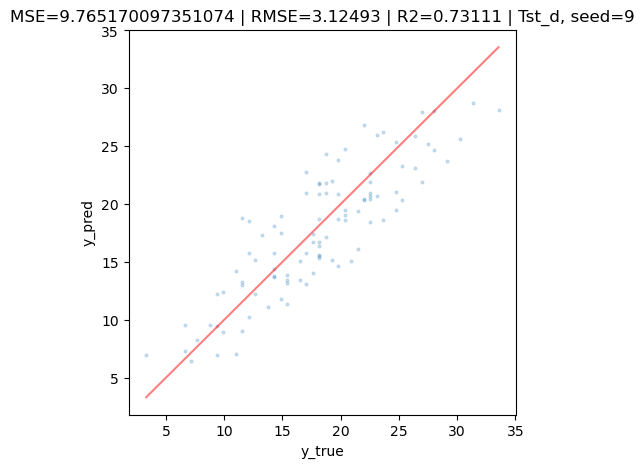

In [33]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)
    result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                           lamb=1e-1,
                           lamb_l1=1,
                           lamb_entropy=2
                           )

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    INPUT_SHAPE = tc_x_test.shape[1]
    prnt_kwrgs = {'in_vars': VAR, 
                    'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                    'title': None,
                    'sample': True,
                    'scale': 0.5}
    
    model2.plot(**prnt_kwrgs)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    #scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
    scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Tst_d, seed={seed}")

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 2.95e+00 | test_loss: 2.80e+00 | reg: 1.37e+01 | : 100%|█| 20/20 [00:04<00:00,  4.41it


saving model version 0.1


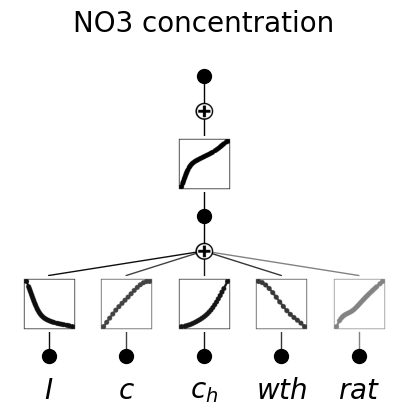

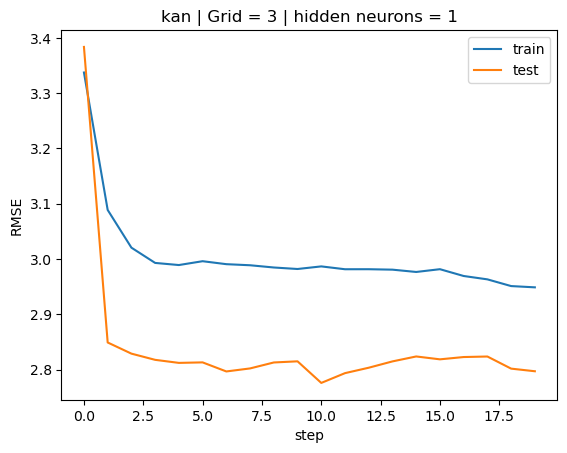

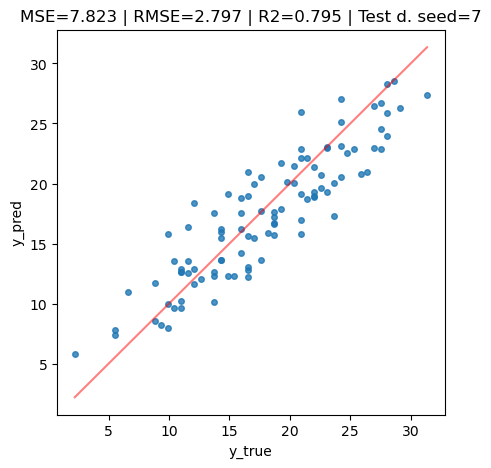

(7.823145, 0.7954519987106323)

In [103]:
# Choose seed and train again
seed = 7
print(f'==========\n- {seed=} -\n==========')

model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=seed, grid=3, k=3)

result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-1,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
INPUT_SHAPE = tc_x_test.shape[1]
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }
model2.plot(**prnt_kwrgs)
plt.show()

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

#scatter_prediction_kan(model2, tc_x_train, tc_y_train, f"Train d. seed={seed}")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, f"Test d. seed={seed}")

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    0.995124  -7.677108           1                1   -0.735422
1      exp    0.999454 -10.813611           2                2   -0.562722
2      x^2    0.999446 -10.791800           2                2   -0.558360
3      log    0.999441 -10.780110           2                2   -0.556022
4    x^0.5    0.999439 -10.775430           2                2   -0.555086


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9951239228248596,
 1)

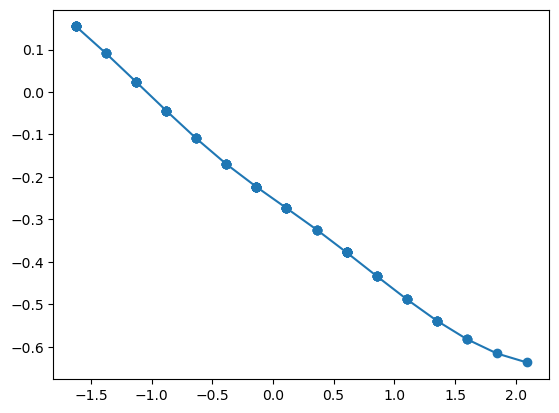

In [99]:
# suggest activation function
l = 0#1
i = 1#0
j = 0#0

inputs = model2.spline_preacts[l][:,j,i]
outputs = model2.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

model2.suggest_symbolic(l,i,j)

In [105]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 1#0
j = 0#0

model2.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2(dataset['train_input'])

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3


| train_loss: 2.99e+00 | test_loss: 2.78e+00 | reg: 1.55e+01 | : 100%|█| 20/20 [00:06<00:00,  3.33it

saving model version 0.4


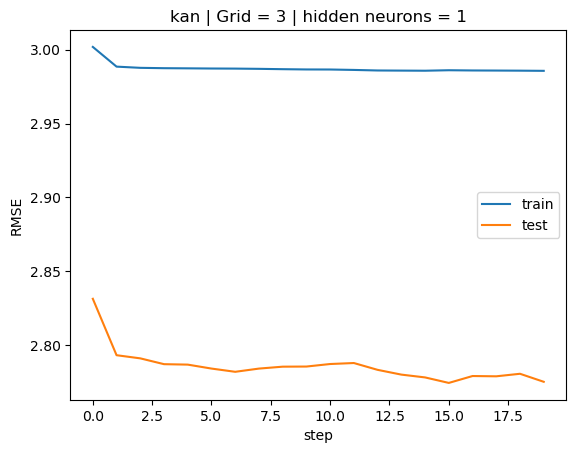

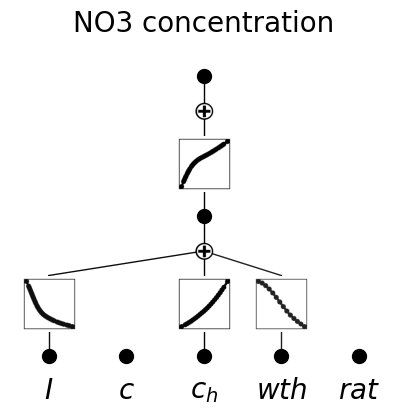

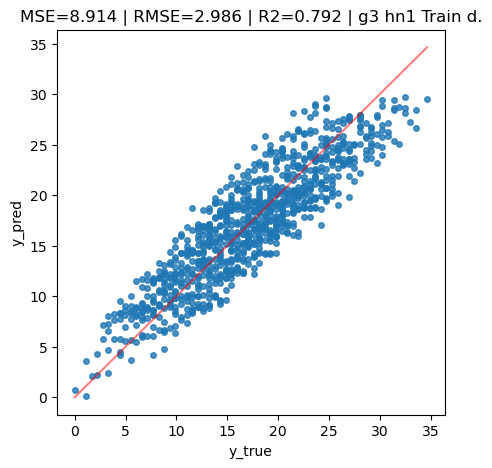

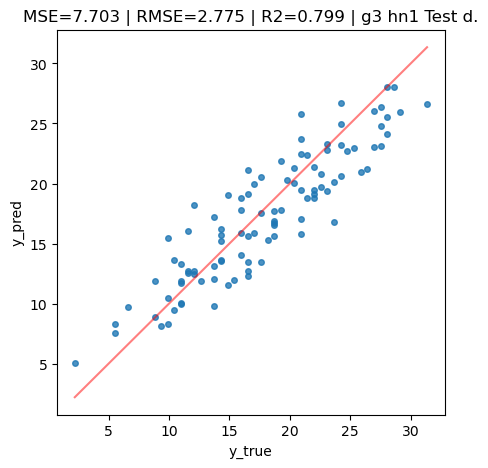

(7.702593, 0.7986040115356445)

In [106]:
# POSTFITTING reduced KAN
result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-3,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()

model2.plot(**prnt_kwrgs)

scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")